# **Text Mining Project - Group 8** 

|      |     Student Name     |     Student ID     |
|---   |         ---          |           ---          |
| 1    |      Mariana Cabral    |       20230532       |
| 2    |      Sofia Pereira       |       20230568	       |
|3| Susana Pires |20230540 |

## Goal: 
**Implement an NLP Classification model able to predict, for each property, if it was unlisted (1) in the next quarter or is still listed (0)**


Docs for organization: <br>
https://docs.google.com/document/d/1cU9rkjof2L1qmxQwBYIpzOMezUiTN0xATmCpiLne1_c/edit?usp=sharing

Link for report: <br>
https://liveeduisegiunl-my.sharepoint.com/:w:/g/personal/20230568_novaims_unl_pt/Ee5Xaa2zAJtOj_6C7T8apkgB3_gYWxfbe4SQxlCq9Ld0PA?e=YFEFAF

## **1. Import Libraries &  Documents:**

### Libraries:

In [1]:
# % installs on environment  // ! installs on base
# https://stackoverflow.com/questions/65547021/difference-between-pip-and-pip-in-python-jupyter-notebook-and-colab

# !pip install bs4
# !pip install nltk
# !pip install langdetect
# !pip install lxml
#!pip install spacy
#! pip install emoji
#!pip install gensim
#!pip install textblob

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags
from langdetect import detect, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# NLTK
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from tqdm import tqdm
import spacy
import emoji
from textblob import TextBlob
import numpy as np
import pickle

# SKLEARN
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Import Datasets:

In [21]:
train = pd.read_excel('Project Corpora/train.xlsx')
train_reviews = pd.read_excel('Project Corpora/train_reviews.xlsx')
test= pd.read_excel('Project Corpora/test.xlsx')
test_reviews = pd.read_excel('Project Corpora/test_reviews.xlsx')

In [22]:
train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [23]:
train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [24]:
test.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [25]:
test_reviews.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


### Documents (Copies of the Datasets):

The **Corpora** is composed by the following documents:

•  _`airbnb_df_train `_(train) (6,248 lines): Contains the Airbnb and host descriptions
(“description” and “host_about” columns), as well as the information regarding the
property listing status (“unlisted” column). A property is considered unlisted (1) if
it got removed from the quarterly Airbnb list and it is considered listed (0) if it
remains on that same list.

• _`airbnb_df_train_reviews`_ (train_reviews) (361,281 lines): This file has all the guests’
comments made to each Airbnb property. Note that there can be more than one
comment per property, not all properties have comments, and comments can
appear in many languages.

• _`airbnb_df_test`_ (test) (695 lines): The structure of this dataset is the same as the train set, except that it does not contain the “unlisted” column.

• _`airbnb_df_test_reviews `_ (test_reviews) (41,866 lines): same srtucter as the train reviews set, but the comments correspond to the properties
present on the test set.

**Important notes** about the relation between  _`airbnb_df_train `_ &  _`airbnb_df_train_reviews`_:
- There can be more than one comment per listing;
- Not all properties have comments;
- Comments can appear in many languages;

In [26]:
airbnb_df_train = train.copy()
airbnb_df_train_reviews = train_reviews.copy()
airbnb_df_test= test.copy()
airbnb_df_test_reviews = test_reviews.copy()

----

## **2. Data Exploration**

<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

**Requirements**
- Analyze the corpora;  (DONE)
- Provide Conclusions; (DONE)
- Provide Visual Information (bar chart, word cloud…) with context;

There are no extra points.

Reference: 
- https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
- https://spotintelligence.com/2023/09/15/exploratory-data-analysis-nlp/

###  **2.1 Documents General Analysis:**

####  **2.1.1 airbnb_df_train & airbnb_df_test**

We start by checking if the indexes in *airbnb_df_train* are unique:

In [27]:
airbnb_df_train['index'].nunique()

6248

Since 6248 is equal to the number of total lines, there are no duplicated indexes and so the column "index"  can be turned into the index of the dataframe corresponding to the "ID" of a certain house:

In [28]:
airbnb_df_train.set_index('index', inplace = True)
airbnb_df_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


Let's do the same verification for *airbnb_df_test*:

In [29]:
airbnb_df_test['index'].nunique()

695

We came to the same conclusion, so the same thing is done for the test set:

In [30]:
airbnb_df_test.set_index('index', inplace = True)
airbnb_df_test.head()

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


We then check for the size of our datasets:

In [31]:
airbnb_df_train.shape, airbnb_df_test.shape

((6248, 3), (695, 2))

We have **6248** records in the train dataset and **695** on the test.

Now let's check the **duplicates**:

In [32]:
airbnb_df_train.duplicated().sum()

192

There are also **192** duplicated entries in the train set.

In [33]:
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(keep = False)]
duplicated_rows.head()

,description,host_about,unlisted
index,,,
17,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
45,"Welcome to this well-appointed, charming and v...",I do not spare any efforts when it comes to tr...,0
58,there are 4 rooms in this apartment. this room...,我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.,0
76,Nesha Guesthouse Lisbon is a surf & beach orie...,I'm an enthusiastic and active person who love...,0
78,"Located in Chiado district, one of the trendie...",Hi! Welcome to Lisbon Five Stars apartments. \...,0


In [34]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 1 to 6248
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6248 non-null   object
 1   host_about   6248 non-null   object
 2   unlisted     6248 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 195.2+ KB


As expected, the ``description`` and the ``host_about`` features are stored as strings, and the ``unlisted`` is stored as an integer. We can see that,  apparently, there are no missing values (or missing text) in any feature.

 **Assumptions:** 
- We will treat duplicated entries as different properties (as per indication of teachers).
- All our text fields have text in different languages (Portuguese, English, French...);


In [35]:
airbnb_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 1 to 695
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  695 non-null    object
 1   host_about   695 non-null    object
dtypes: object(2)
memory usage: 16.3+ KB


####  **2.1.2 airbnb_df_train_review & airbnb_df_test_review**

Let´s check the shape:

In [36]:
airbnb_df_train_reviews.shape, airbnb_df_test_reviews.shape

((361281, 2), (41866, 2))

We have **361281** reviews in train and **41866** in test.

This shows that the variable `comments` contains a lot more information than other variables. 
We now need to understand if this information is revelant/coherent for the problem.

**1) Does every house has comments?**


In [37]:
# Checking the unique values of the index and counting them
unique_indices = airbnb_df_train_reviews["index"].unique()

# Checking how many unique indexes are there. With this information we can see how many properties are in this dataset.
print("Total houses that have at least a comment in reviews:", len(unique_indices))

Total houses that have at least a comment in reviews: 4245


**No** => Since the total number of houses is 6248, and the different house indexes in reviews are 4245, we confirm that there are houses that do not have comments.

**2) Are comments important for  listing?**

In [38]:
# Get the set of house indices from the reviews dataset
reviewed_houses_indices = set(airbnb_df_train_reviews['index'])

# Get the set of all house indices from the houses dataset
all_houses_indices = set(train['index'])

# Find the houses with no comments
houses_with_no_comments_indices = all_houses_indices - reviewed_houses_indices

# Filter the houses dataset for houses with no comments
houses_with_no_comments = train[train['index'].isin(houses_with_no_comments_indices)]

houses_with_no_comments['unlisted'].value_counts()

unlisted
1    1441
0     562
Name: count, dtype: int64

In [39]:
houses_with_comments= train[train['index'].isin(reviewed_houses_indices)]
houses_with_comments['unlisted'].value_counts()

unlisted
0    3978
1     267
Name: count, dtype: int64

**Yes** 
* If unlisted=0, it indicates that the house remains listed in the next quarter, with a higher number of houses having comments.

* If unlisted=1, it signifies that the house is removed from the listings in the next quarter, with a higher number of houses having no comments.

* **Idea:** Having comments is crucial in determining whether a house will be listed in the next trimester.

In [40]:
airbnb_df_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


There are 2 missing values (or missing text) in the feature coment.

In [41]:
airbnb_df_test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41866 entries, 0 to 41865
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     41866 non-null  int64 
 1   comments  41866 non-null  object
dtypes: int64(1), object(1)
memory usage: 654.3+ KB


### **2.2 Feature Analysis**

####  **2.2.1 `unlisted`** (target variable)

In [42]:
airbnb_df_train['unlisted'].describe()

count    6248.000000
mean        0.273367
std         0.445724
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [43]:
airbnb_df_train['unlisted'].unique()

array([0, 1], dtype=int64)

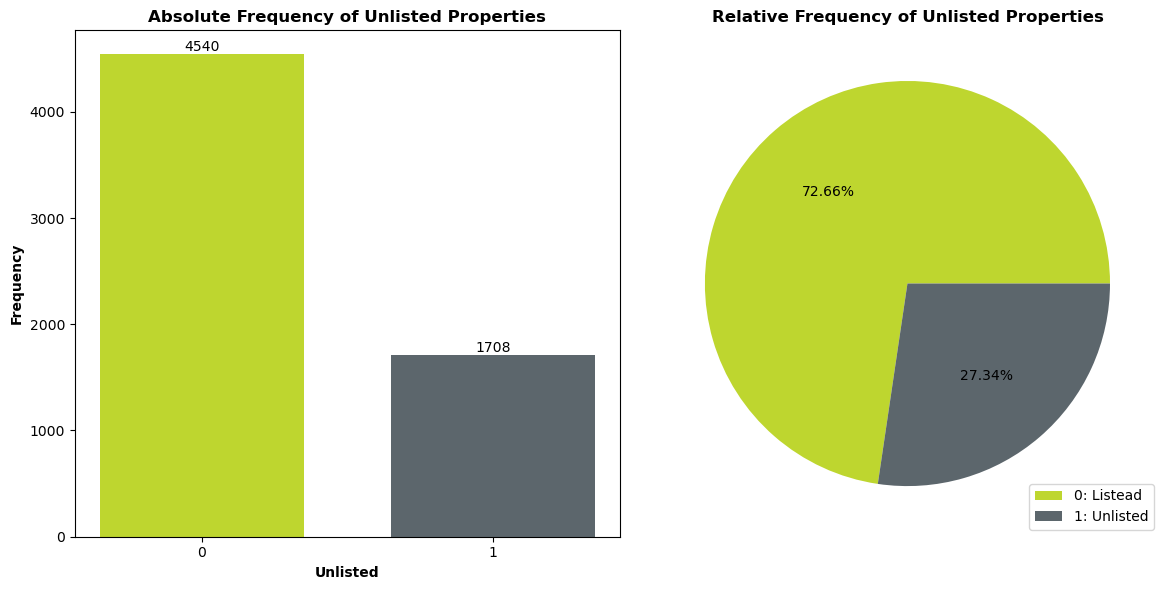

In [44]:
# Data
unlisted_counts = airbnb_df_train['unlisted'].value_counts()
total_properties = unlisted_counts.sum()
percentages = (unlisted_counts / total_properties) * 100

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for frequency
bar_colors = ['#BED62F', '#5C666C']
bar_labels = ['0', '1']
bars = axs[0].bar(unlisted_counts.index.astype(str), unlisted_counts, color=bar_colors, width=0.7)
axs[0].grid(False)
axs[0].set_title('Absolute Frequency of Unlisted Properties', fontweight='bold')
axs[0].set_xlabel('Unlisted', fontweight='bold')
axs[0].set_ylabel('Frequency', fontweight='bold')
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_xticks(unlisted_counts.index)
axs[0].set_xticklabels(bar_labels)
for p in bars:
    axs[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Add legend
legend_labels = ['0: Listead ', '1: Unlisted']

# Pie chart for percentages
pie_colors = ['#BED62F', '#5C666C']
wedges, texts, autotexts = axs[1].pie(percentages, autopct='%1.2f%%', colors=pie_colors)
axs[1].set_title('Relative Frequency of Unlisted Properties', fontweight='bold')

# Add legend
axs[1].legend(wedges, legend_labels, loc='lower right')

plt.tight_layout()
plt.show()


In [45]:
airbnb_df_train['unlisted'].value_counts(normalize=True)*100

unlisted
0    72.663252
1    27.336748
Name: proportion, dtype: float64

**Conclusions - Target Analysis:**
* No **mising values**  (i.e count = total number of lines)
* No **unexpected values** 
* There is a clear **unbalance**: around 73% of the training instances represent airbnb's that remain listed, while only 27% represent airbnb's that were unlisted.
    - This is an important characteristic of the data, as unbalanced data needs to be adressed so it does not affect the performance of our classification models.

#### **2.2.2 `description`**

##### **1) Overall Analysis**

In [31]:
airbnb_df_train['description'].describe()

count                                  6248
unique                                 6023
top       <b>License number</b><br />Exempt
freq                                     19
Name: description, dtype: object

In [32]:
airbnb_df_train['description'].isna().sum()

0

In [33]:
airbnb_df_train['description'].duplicated().sum()

225

**Conclusions**:
* The **most common description** is repeated 19 times, and there are 6023 unique property descriptions, so that there are **duplicated descriptions**.
* There are **no missing values**.



##### **2) Word Count** 
Turn text into words to better analyse it:
Turning our descriptions into tokens and counting how many tokens exist in each description:

In [34]:
airbnb_df_train['word_count_descr']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_descr']].head() #number of tokens

,description,word_count_descr
index,,
1,"This is a shared mixed room in our hostel, wit...",127
2,"O meu espaço fica perto de Parque Eduardo VII,...",23
3,Trafaria’s House is a cozy and familiar villa ...,170
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
5,Joli appartement en bordure de mer.<br /> 2 m...,101


In [35]:
airbnb_df_train.word_count_descr.describe().round(2)

count    6248.00
mean      132.86
std        48.08
min         3.00
25%        99.00
50%       157.00
75%       167.00
max       210.00
Name: word_count_descr, dtype: float64

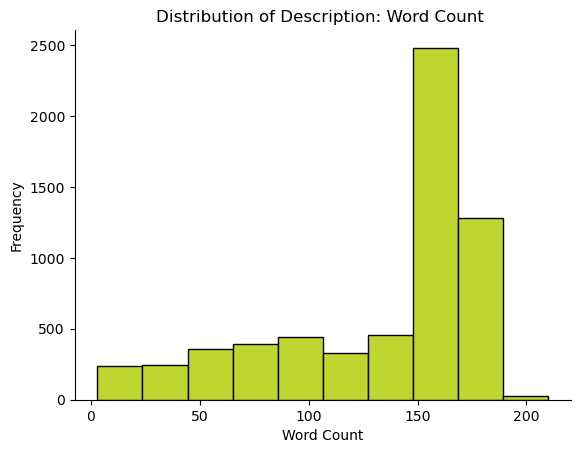

In [36]:
airbnb_df_train['word_count_descr'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of Description: Word Count ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description has 210 words
- The smallest description has only 3 words
- On average, descriptions have around 133 words
- The descripiton filed contains text with many different sizes, but is most commonly around [150,170] words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [37]:
all_words_descr = ' '.join(airbnb_df_train['description']).split()

In [38]:
freq_descr = pd.Series(all_words_descr).value_counts() #see frequency of words

Cheking the **most common words**:

In [39]:
freq_descr.sort_values(ascending=False)[0:25]

the             31323
and             27698
a               25540
/><br           17380
to              15328
of              15122
in              13866
with            13649
is              12083
de               6918
apartment        6841
for              6153
you              6140
<br              5328
has              4863
space</b><br     4814
/><b>The         4670
from             4363
e                4288
/>The            4144
The              3426
are              3155
room             3016
located          2944
2                2937
Name: count, dtype: int64

Visualizing using a barplot:

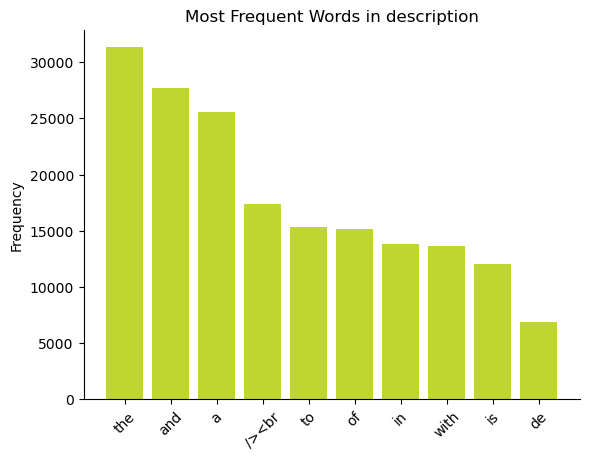

In [40]:
x_labels = freq_descr.index[0:10]
values = freq_descr[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

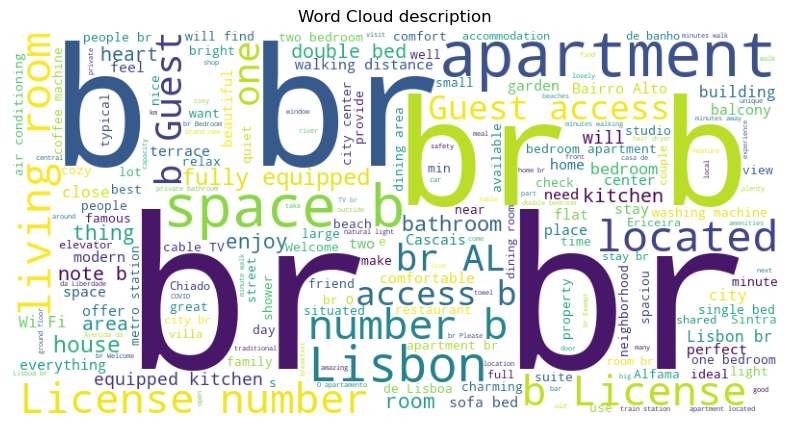

In [41]:
# Joining all the descriptions into a single string
all_reviews_descr = ' '.join(airbnb_df_train['description'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud description')
plt.show()

**Conclusions**:

There are clearly a lot of **uniformative words** that can be considered *stop words*, *tags* or *non-alphanumeric*, such as 'br', 'and' 'the'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.3 `host_about`**

##### **1) Overall Analysis**

In [42]:
airbnb_df_train['host_about'].describe()

count                                                  6248
unique                                                 2803
top       We are Feels Like Home Holiday Rentals.\nA com...
freq                                                    153
Name: host_about, dtype: object

In [43]:
airbnb_df_train['host_about'].isna().sum()

0

In [44]:
airbnb_df_train['host_about'].duplicated().sum()

3445

**Conclusions**:
* There are only 2.803 **unique host_about descriptions**. This might be due to the fact that the same host might have many properties. Additionally, the **most common host_about** information is repeated 153 times.
* There are **no missing values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *host_about*

In [45]:
airbnb_df_train['word_count_host']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host']].head() #number of tokens

,host_about,word_count_host
index,,
1,Alojamento Local Registro: 20835/AL,4
2,"I am friendly host, and I will try to always b...",24
3,"I am a social person liking to communicate, re...",45
4,Hello!_x000D_\nI m Portuguese and i love to me...,31
5,Nous sommes une famille avec deux enfants de 1...,37


In [46]:
airbnb_df_train.word_count_host.describe().round(2)

count    6248.00
mean       73.65
std        79.66
min         1.00
25%        26.00
50%        55.00
75%       101.00
max      1387.00
Name: word_count_host, dtype: float64

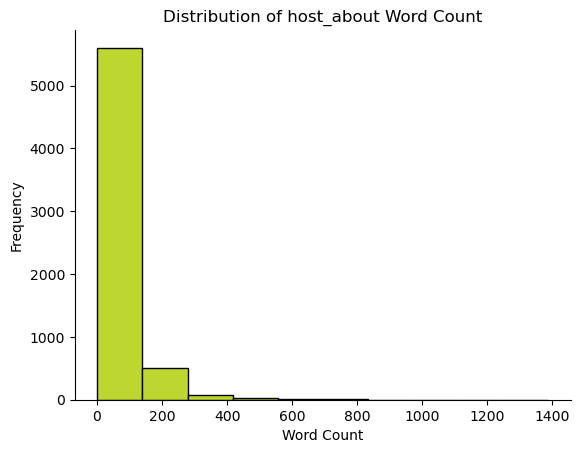

In [47]:
airbnb_df_train['word_count_host'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of host_about Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description of the host has 1387 words
- The smallest description of the host has only 1 word
- On average, descriptions of the hosts  have around 74 words
- The *host_about* filed has generally smaller text [0,100] words, but also has extreme outliers with 10 times more words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [48]:
all_words_host= ' '.join(airbnb_df_train['host_about']).split()

In [49]:
freq_host = pd.Series(all_words_host).value_counts() #see frequency of words

Cheking the most common words:

In [50]:
freq_host.sort_values(ascending=False)[0:20]

and        16358
to         13291
the        10797
a          10535
in          9860
of          6524
I           6419
you         6248
de          4325
We          4206
our         4004
e           3980
_x000D_     3971
for         3864
with        3819
is          3506
we          3481
are         2929
have        2825
my          2750
Name: count, dtype: int64

Visualizing using a barplot:

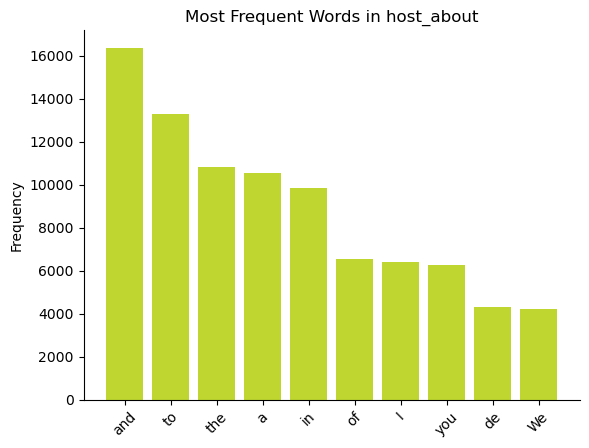

In [51]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in host_about')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

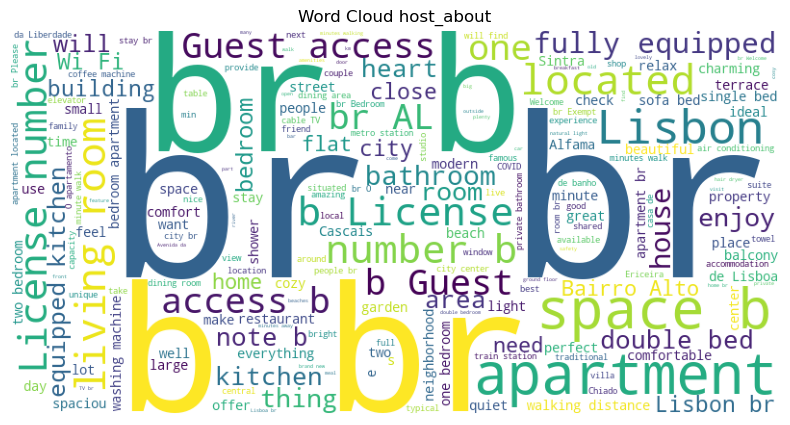

In [52]:
# Joining all the host_about into a single string
all_reviews_host = ' '.join(airbnb_df_train['host_about'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud host_about')
plt.show()

**Conclusions:**

There are clearly a lot of uniformative words that can be considered stop words, tags or non-alphanumeric, such as 'br', 'and' 'to'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.4 `comments`**

##### **1) Overall Analysis**

In [53]:
airbnb_df_train_reviews['comments'].isna().sum()

2

In [54]:
rows_with_nan_comments = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].isna()]
rows_with_nan_comments

,index,comments
97996,1654,NaN
334443,5789,NaN


In [55]:
airbnb_df_train_reviews['comments'].duplicated().sum()

6781

**Conclusions:**

We have **2 missing values** and have **many duplicated values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *comments*

In [56]:
airbnb_df_train_reviews['word_count_rev']  = airbnb_df_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_reviews[['comments','word_count_rev']].head() #number of tokens

,comments,word_count_rev
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [57]:
airbnb_df_train_reviews.word_count_rev.describe().round(2)

count    361281.00
mean         47.97
std          46.79
min           1.00
25%          18.00
50%          36.00
75%          63.00
max        1019.00
Name: word_count_rev, dtype: float64

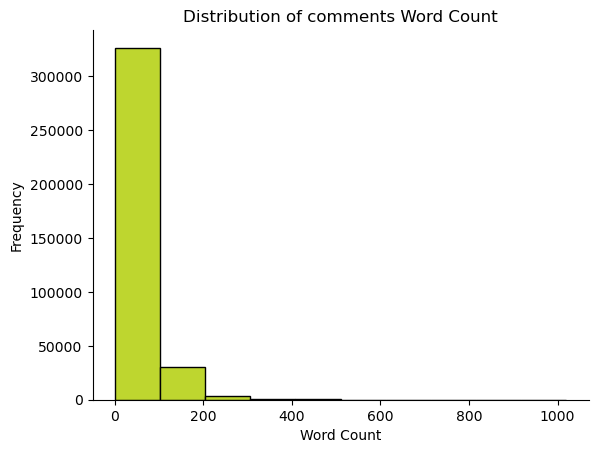

In [58]:
airbnb_df_train_reviews['word_count_rev'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of comments Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest comment has 1019 words
- The smallest comment has only 1 word
- On average, comments of the hosts  have around 48 words
- Just as with *host_about*, most *comments* have around [1,63] words but some outliers are 10 times bigger.

##### **3) Word Analysis** 
We now analyse each word individually:

In [59]:
#all_words_rev= ' '.join(airbnb_df_train_reviews['comments']).split()

The code line from above would not work as we are dealing with a variable with missing values encoded as *NaN*. This being said, we explore the problem further:

In [60]:
problematic_indices = []

for index, comment in airbnb_df_train_reviews['comments'].items():
    if isinstance(comment, float):
        problematic_indices.append(index)

problematic_rows = airbnb_df_train_reviews.loc[problematic_indices]
print(problematic_rows)

        index comments  word_count_rev
97996    1654      NaN               1
334443   5789      NaN               1


In [61]:
#The problem occurs because we have missing values, so let's no consider them (drop them)
comments_without_missing = airbnb_df_train_reviews['comments'].dropna()
all_words_rev = ' '.join(comments_without_missing).split()

In [62]:
freq_rev = pd.Series(all_words_rev).value_counts() #see frequency of words

Cheking the most common words:

In [63]:
freq_rev.sort_values(ascending=False)[0:15]

and          553157
the          515963
a            398631
to           328675
is           258191
in           249469
was          239807
of           174087
very         156654
The          143987
for          141658
de           139290
with         115782
apartment    114848
we            98283
Name: count, dtype: int64

Visualizing using a barplot:

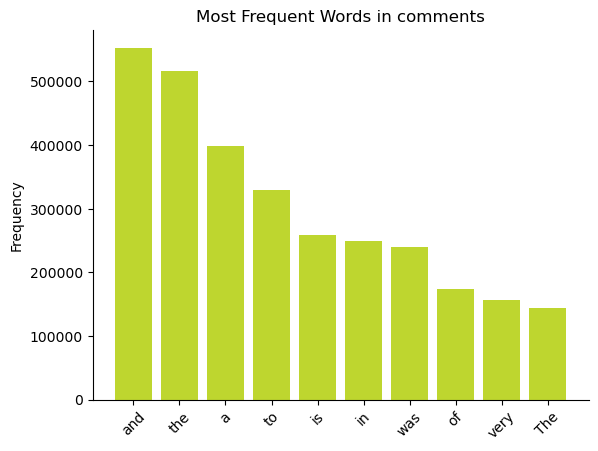

In [64]:
x_labels = freq_rev.index[0:10]
values = freq_rev[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in comments')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

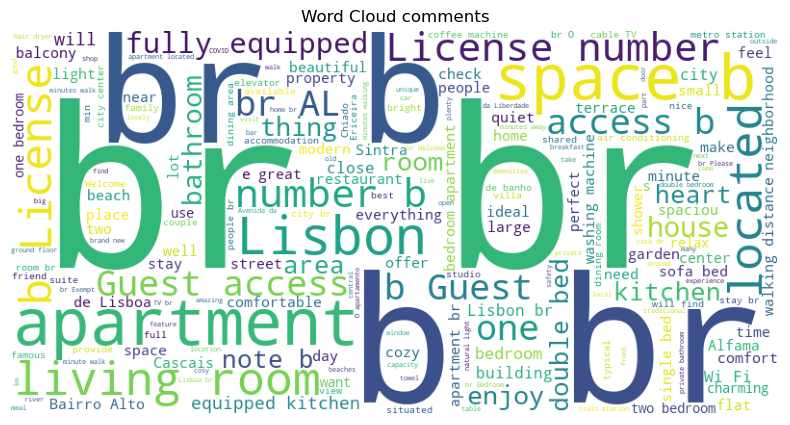

In [65]:
# Joining all the comments into a single string
all_reviews_rev = ' '.join(comments_without_missing)
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud comments')
plt.show()

**Note:**

Although we have conducted an analysis suggesting that comments may be important for unlisting, we acknowledge that sometimes comments can consist of empty strings, spaces, dots, or punctuation marks that don't provide useful information for our problem context. 
Therefore, let´s check comments with 5 or less characters and determine the number of such comments in the dataset.

In [66]:
feature = ['comments']

for entry in feature:
    #select only comments with a length less than 5 characters 
    short_values = airbnb_df_train_reviews[airbnb_df_train_reviews[entry].str.len() < 5][entry].unique()
    for comment in short_values:
        print(comment)

top
.
I
👍
Good
q
-
Top
bien
Bien
Bom.
非常满意
RAS
Bom
O
♥️
show
💚
ø
....
Na
🤙🏼
👍🏼
A
Si
...
nice
J
G
..
idem
Idem
😊
K
Ras
👌
å
Ok
Nice
Nee
****
Xxx
/
5/5
👍🏼👍🏼
:-)
L
r
🙂
!
Hi
Top!
…
🔝
Bb
👍🏻
Best
좋습니다
Nul
❤️
10
🇵🇹
x
nvt
´
!!!
NC
Ok.
E
 ...
no
😍😍😍
좋았음
🙏🏻
xxx
good
👌👌👌
ok
:)
很接地气
,
OK
N.
No
X
👍👍👍
We
D
n
非常完美
Hduj
aa
non
5*
אש
Kind
N/a
C
Gut
👍👍
좋아요
👌🏻👌🏻
S
6*!!
1
Omit
Cool
Amei
N
nada
😎😎😎😎
  . 
A+++
😉
Gh
+
Goed
Z
👌🏼👌🏼
非常好
Xx
1A
M
•
🔝🔝🔝
. 
GG
A*
👌🏾
Hh
Fab!
都很好！
挺好的
非常好👍
非常干净
_
v
cfgx
B
A a
P
五星推荐
‘
T
✌️🪨
Tks
🙏
رائع
2/5
***
Gos
5🌟
Top 
Ds
…..
✔️
👍👍👍👍
  👌🏻
😘
Ok😊
a
5⭐️
;-))
Nada
👌🏻
?
좋아요!
1 A
gut
Df
Nn
TB
🙌🏻
Veld
SN
+++👍
top!
✨
🙌🏾
0
Boa
Test
Ya
无
<3
😀
很舒适
100%
👍👌
💗
5 ⭐️
🤗
g
Grat
tnx
👌🏽
Aaaa
很好
Oui
👍🏽
☹️👎🏽
5*!
ooo
🤨
  C
Q
👌👌
还可以
Fine
Mega
Okay
**
体验不错
Thx
👍🏼👏🏼
we
i
5✨
9
Nvt
ciao
👍🏾
N/à
非常喜欢
位置不错
hu
👌🏼
👌👍
Apa
U
Todo
R
p
很干净
boa
d
--
BIEN
8.0
👍🏻🤟🏻
The 
Mhe
none
SO
cool
👏🏻
bom
好
很棒！
超赞！
9/10
Bom!
c
n/A
xx
..!
Yes!
ppp
Arnm
*
H
Yo
Guay
😉👌
The
☹️
🤟👍
🎷🦫
–
—-
Www
RAS.
: )
Boa.
yes
Very
Hyvä
5 ⭐
Fair
top.
Boa!

**Conclusions:**
There are clearly a lot of uniformative words that can be considered stop words, tags, emojis or non-alphanumeric, such as 'br', 'and' 'the'.\
 These words should be correctly pre-processed as to not affect the outcome of our final analysis.

### **2.3 Multi-Language Analysis**

As was noted earlier, our text is written in many different languages. An important step of our analysis is to understand the proportions in which each language is present in our text, as to select the best approach going forward.

There are many possible libraries that can be used to detect languages from a string. Considering the following article: https://medium.com/@monigrancharov/text-language-detection-with-python-beb49d9667b3 , using *LangDetect* is seen as the appropriate choice:

In [ ]:
def detect_language_with_langdetect(text):
    """
    This function recieves as input a piece of text and return the language it corresponds to.
    It uses Langdetect as the detection algorithm.
    """
    try:
        return detect(text) # return the language with highest probability
    except: return "Unknown" # if does not recognise language

In [ ]:
#Identifying the language of "description" & "host_about" in airbnb_df_train
airbnb_df_train['desc_lang'] = airbnb_df_train['description'].apply(detect_language_with_langdetect)
airbnb_df_train['ha_lang']=airbnb_df_train['host_about'].apply(detect_language_with_langdetect)

In [ ]:
airbnb_df_train[['desc_lang', 'ha_lang' ]].describe().T

,count,unique,top,freq
desc_lang,6248,12,en,5106
ha_lang,6248,29,en,4446


In [ ]:
#Identify language of "comments" in airbnb_df_train_reviews
airbnb_df_train_reviews['com_lang'] = airbnb_df_train_reviews['comments'].apply(detect_language_with_langdetect)

Saving our data into a csv so it is faster to acces it in the future:

In [ ]:
airbnb_df_train.to_csv('airbnb_df_train_lang.csv', index=False)
airbnb_df_train_reviews.to_csv('airbnb_df_train_reviews_lang.csv', index=False)

In [ ]:
airbnb_df_train_reviews['com_lang'].describe()

count     361281
unique        44
top           en
freq      232321
Name: com_lang, dtype: object

Checking our dataframes:

In [ ]:
airbnb_df_train.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang
index,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr


In [ ]:
airbnb_df_train_reviews.head()

,index,comments,word_count_rev,com_lang
0,1,this is a very cozy and comfortable house to s...,28,en
1,1,good<br/>,1,cy
2,1,"My first hostel experience, and all I have to ...",261,en
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de
4,1,"It was fine for a dorm, but I think for the pe...",27,en


Having each languages identified, we further analyse these variables:

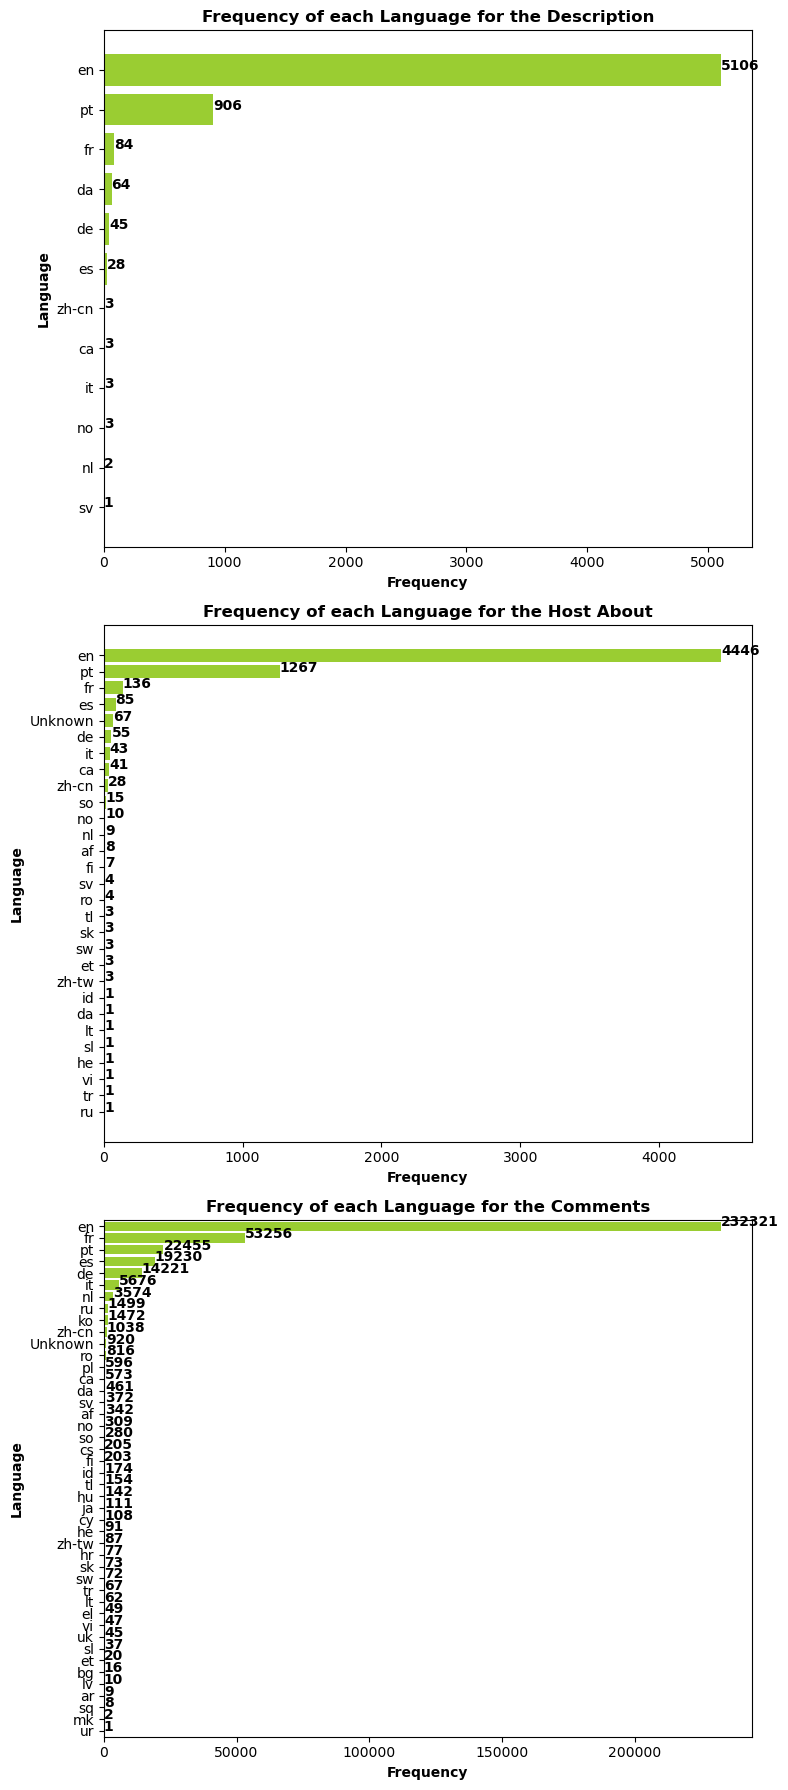

In [ ]:
# Data
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Horizontal bar plot for description language
desc_lang_counts_sorted = desc_lang_counts.sort_values(ascending=True)
axs[0].barh(desc_lang_counts_sorted.index, desc_lang_counts_sorted, color='yellowgreen')
axs[0].grid(False)
axs[0].set_title('Frequency of each Language for the Description', fontweight='bold')
axs[0].set_xlabel('Frequency', fontweight='bold')
axs[0].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(desc_lang_counts_sorted):
    axs[0].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for host about language
ha_lang_counts_sorted = ha_lang_counts.sort_values(ascending=True)
axs[1].barh(ha_lang_counts_sorted.index, ha_lang_counts_sorted, color='yellowgreen')
axs[1].grid(False)
axs[1].set_title('Frequency of each Language for the Host About', fontweight='bold')
axs[1].set_xlabel('Frequency', fontweight='bold')
axs[1].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(ha_lang_counts_sorted):
    axs[1].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for comment language
com_lang_counts_sorted = com_lang_counts.sort_values(ascending=True)
axs[2].barh(com_lang_counts_sorted.index, com_lang_counts_sorted, color='yellowgreen')
axs[2].grid(False)
axs[2].set_title('Frequency of each Language for the Comments', fontweight='bold')
axs[2].set_xlabel('Frequency', fontweight='bold')
axs[2].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(com_lang_counts_sorted):
    axs[2].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Adjusting vertical scale for comments language plot
axs[2].set_ylim(-0.5, len(com_lang_counts_sorted) - 0.5)

plt.tight_layout()
plt.show()


Regarding the distribution of relative frequency, we'll create pie charts. However, for better interpretation, each chart will only represent languages with a representation above 5%. All others will be included in the "Others" category.

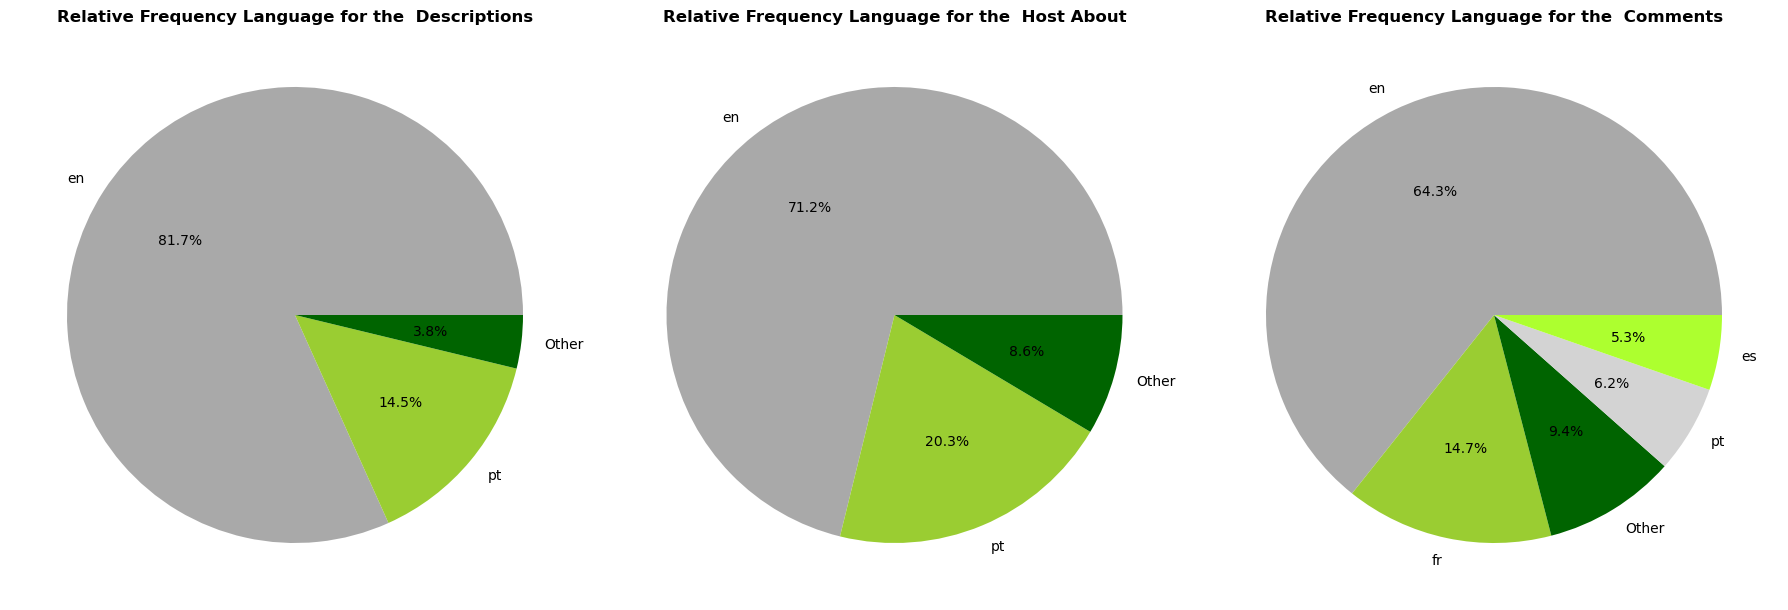

In [88]:
# let's aggregate all the languages in less than 5% of the data for each column in one category called other

#Function to aggregate the small categories
def aggregate_categories(counts):
    total_count = counts.sum()
    filtered_counts = counts[counts / total_count * 100 > 5]
    other_count = total_count - filtered_counts.sum()
    return filtered_counts, other_count

# Counts
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Aggregate small categories
desc_lang_counts_filtered, desc_lang_others = aggregate_categories(desc_lang_counts)
ha_lang_counts_filtered, ha_lang_others = aggregate_categories(ha_lang_counts)
com_lang_counts_filtered, com_lang_others = aggregate_categories(com_lang_counts)

# Create temporary columns
airbnb_df_train['desc_lang_temp'] = airbnb_df_train['desc_lang'].apply(lambda x: x if x in desc_lang_counts_filtered else 'Other')
airbnb_df_train['ha_lang_temp'] = airbnb_df_train['ha_lang'].apply(lambda x: x if x in ha_lang_counts_filtered else 'Other')
airbnb_df_train_reviews['com_lang_temp'] = airbnb_df_train_reviews['com_lang'].apply(lambda x: x if x in com_lang_counts_filtered else 'Other')



# Use the temporary columns to plot the pie charts
desc_lang_counts_temp = airbnb_df_train['desc_lang_temp'].value_counts()
ha_lang_counts_temp = airbnb_df_train['ha_lang_temp'].value_counts()
com_lang_counts_temp = airbnb_df_train_reviews['com_lang_temp'].value_counts()

# Define colors
colors = ['darkgrey','yellowgreen', 'darkgreen', 'lightgrey', 'greenyellow']

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for description language
axs[0].pie(desc_lang_counts_temp, labels=desc_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[0].set_title('Relative Frequency Language for the  Descriptions', fontweight='bold')

# Pie chart for host about language
axs[1].pie(ha_lang_counts_temp, labels=ha_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Relative Frequency Language for the  Host About', fontweight='bold')

# Pie chart for comment language
axs[2].pie(com_lang_counts_temp, labels=com_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[2].set_title('Relative Frequency Language for the  Comments', fontweight='bold')

plt.tight_layout()
plt.show()


**Conclusion**

|                        |    Description  |     Host About    |        Comments |
|---                     |         ---     |           ---     |   ---           |
| # Distintic languages  |        12       |       30          |  44
| +/-95 %   |    en-pt        |      en-pt       |  en-fr-pt-es |


### **2.4  Checking for URL's, dates and emojis:**

Our text can include url's and dates that need to be normalized. An analysis is performed to better understand the presence of these elements in the text:

##### **URL:**

https://www.geeksforgeeks.org/python-check-url-string/

In [67]:
def Find(string):
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, string)
    return [x[0] for x in url]

In [68]:
def find_count_url(data):
    url = []
    for text in data:
        if Find(text)!= []:
            url.append(Find(text)),
    return len(url), url

In [69]:
print('Description has',find_count_url(airbnb_df_train['description'])[0], 'URLs.')
print('host_about has',find_count_url(airbnb_df_train['host_about'])[0], 'URLs.')
print('Comments have', find_count_url(comments_without_missing)[0], 'URLs')

Description has 23 URLs.
host_about has 37 URLs.
Comments have 51 URLs


Example of present Url:

In [70]:
find_count_url(comments_without_missing)[1]

[['https://packathon.in'],
 ['https://abnb.me/aIxlMuJU9ib'],
 ['http://www.tripadvisor.com/Restaurant_Review-g3874225-d6957429-Reviews-Manteigaria-Lisbon_District_Central_Portugal.html'],
 ['www.Turisma.pt'],
 ['https://www.aartedaterra.pt/en/'],
 ['www.travelhotspots.nl'],
 ['http://lisboaautentica.com/fr/'],
 ['https://de.wikipedia.org/wiki/Mouraria'],
 ['http://www.figaroslisboa.com'],
 ['https://www.yelp.com/biz/time-out-market-lisboa'],
 ['www.gosoohi.com'],
 ['https://www.airbnb.com/rooms/6353661'],
 ['https://www.youtube.com/watch?v=SzHHsbJ_LyM'],
 ['https://www.mafrense.pt/FileGet.aspx?FileId=6610'],
 ['https://www.youtube.com/channel/UCe5Kl8UQH0OXC9KuJ9PzkLw?view_as=subscriber'],
 ['http://www.hamburgueriadobairro.pt'],
 ['https://www.facebook.com/CurtindoPortugal/'],
 ['https://www.visitportugal.com/en/content/festas-de-lisboa'],
 ['http://www.conserveiradelisboa.pt/en'],
 ['www.facebook.com/avelhagaiteira'],
 ['https://goo.gl/maps/x3abCKBrnDR2'],
 ['www.portugalicious.pt'],


There is a clear presence of url's in our data that needs to de dealt with accordingly.

#### **Dates:**

Finding dates can be a more complex approach, since dates can come in many formats. Nevertheless, in a first approach, a simple function is created to find dates with the typical yyyy-mm-dd or dd-mm-yyyy format.

In [71]:
def find_dates(data):
    date_patterns = [
        r'\d{4}-\d{2}-\d{2}',      # YYYY-MM-DD
        r'\d{4}/\d{2}/\d{2}',      # YYYY/MM/DD
        r'\d{2}/\d{2}/\d{4}',      # MM/DD/YYYY
        r'\d{2}-\d{2}-\d{4}',      # DD-MM-YYYY
    ]
    
    dates = []
    for text in data:
        for pattern in date_patterns:
            date_matches = re.findall(pattern, text)
            if date_matches:
                dates.extend(date_matches)
    return len(dates), dates


In [72]:
print('There are',find_dates(airbnb_df_train['description'])[0], 'dates in description', find_dates(airbnb_df_train['description'])[1])
print('There are',find_dates(airbnb_df_train['host_about'])[0], 'dates in host_about', find_dates(airbnb_df_train['host_about'])[1])
print('There are',find_dates(comments_without_missing)[0], 'dates in comments', find_dates(comments_without_missing)[1])

There are 4 dates in description ['27/03/2022', '10/04/2022', '24/06/2020', '01-01-2019']
There are 0 dates in host_about []
There are 19 dates in comments ['26/11/2018', '06/12/2018', '20-06-2013', '25-06-2013', '17/10/2016', '18/02/2022', '11/03/2018', '01/09/2018', '05/09/2018', '2018-08-08', '2018-08-13', '26/01/2018', '30/05/2019', '07/07/2015', '22/07/2019', '02/01/2019', '2017-04-05', '2017-04-05', '25/08/2022']


It is clear that there are dates in our text data. This format needs to be dealt with accordingly.

#### **Emojis**:

We start by checking the presence of emjois made by chracters such as :) :

In [73]:
#create a list of writen emojis to look for:
emoji_write = [':)',':(',':(',':D',':P',';)',':*','<3',':|',':-)',':-(',':-D',':-P',';-)',':-*',':-|',':-O',':-[',':-]',':^)',':3',':\')',':>',':o',':-o','O_O','T_T',':\'(','D:',':-[']

In [74]:
def find_emojicons(data):
    emoji_pattern = re.compile('|'.join(re.escape(pattern) for pattern in emoji_write))  # compile turns patterns that are strings into regex pattern objects
    emojis = []
    count_entries = 0
    for text in data:
        s=0
        emoji_matches = emoji_pattern.findall(text)
        if emoji_matches:
            s+=1
            emojis.extend(emoji_matches)
        if s!=0:
            count_entries+=1
    return len(emojis), set(emojis), count_entries

In [75]:
print('There are',find_emojicons(airbnb_df_train['description'])[0], 'emojis in description', find_emojicons(airbnb_df_train['description'])[1],'in',find_emojicons(airbnb_df_train['description'])[2],'descriptions' )
print('There are',find_emojicons(airbnb_df_train['host_about'])[0], 'emojis in host_about', find_emojicons(airbnb_df_train['host_about'])[1],'in', find_emojicons(airbnb_df_train['host_about'])[2], 'host_about')
print('There are',find_emojicons(comments_without_missing)[0], 'emojis in comments', find_emojicons(comments_without_missing)[1], 'in',find_emojicons(comments_without_missing)[2], 'comments')

There are 266 emojis in description {':3', ':o', ';)', ';-)', ':-)', 'D:', ':(', ':)', '<3'} in 222 descriptions
There are 733 emojis in host_about {';)', ':-)', ';-)', ':)', ':D', '<3', ':-D'} in 616 host_about
There are 19914 emojis in comments {':o', ';)', ':*', ':>', ':-)', ':(', ':|', ':-D', ':-*', 'D:', ':-(', ':)', ":'(", ':3', ':P', ":')", ';-)', ':D', ':-P', ':^)', '<3'} in 18252 comments


There are many writen emojis writen in our text.

And we now look into actual emojis:

In [76]:
def find_emojis(data):
    all_unique_emojis = set()
    count_entries = 0
    for text in data:
        unique_emojis = {char for char in text if char in emoji.EMOJI_DATA}
        all_unique_emojis.update(unique_emojis)
        if unique_emojis:
            count_entries+=1

    return  len(all_unique_emojis), all_unique_emojis, count_entries

In [77]:
print('There are',find_emojis(airbnb_df_train['description'])[0], 'emojis in description', find_emojis(airbnb_df_train['description'])[1],'in',find_emojis(airbnb_df_train['description'])[2],'descriptions' )
print('There are',find_emojis(airbnb_df_train['host_about'])[0], 'emojis in host_about', find_emojis(airbnb_df_train['host_about'])[1],'in', find_emojis(airbnb_df_train['host_about'])[2], 'host_about')
print('There are',find_emojis(comments_without_missing)[0], 'emojis in comments', find_emojis(comments_without_missing)[1], 'in',find_emojis(comments_without_missing)[2], 'comments')

There are 30 emojis in description {'💯', '✈', '😂', '🚇', '☑', '❤', '🚕', '✔', '☺', '☀', '😊', '♥', '⭐', '🤗', '📡', '🌴', '®', '⚠', '🙂', '🥳', '😉', '💙', '🚙', '☝', '▪', '🌉', '🏖', '✅', '🙌', '🚗'} in 36 descriptions
There are 1 emojis in host_about {'✈'} in 1 host_about
There are 307 emojis in comments {'🔴', '🕊', '🍞', '🏿', '♂', '😊', '♥', '🌶', '💻', '🪨', '😋', '🌊', '💝', '😉', '👋', '📞', '💃', '😞', '🤘', '🤌', '✅', '😷', '🥞', '👊', '💯', '🎈', '⛔', '🍴', '😡', '👻', '😍', '🌹', '🌈', '😎', '🧡', '☹', '☕', '⬛', '🏼', '🐟', '👌', '🏴', '🥂', '💓', '👉', '🐱', '🏝', '😕', '✌', '🤞', '🤢', '👆', '🚉', '👍', '🏻', '⚡', '🏽', '😻', '😖', '❌', '💕', '🎒', '🍀', '👀', '🚌', '😒', '😝', '😸', '🎶', '🙆', '😃', '🧁', '🚻', '♾', '😱', '🍒', '💑', '💚', '🧽', '🤦', '📢', '🙏', '🍹', '☀', '🤕', '😬', '🔝', '🧐', '😆', '🉐', '🚊', '😚', '❣', '🥐', '😇', '😛', '🗺', '🙌', '🤝', '🥲', '🤤', '🍪', '🌲', '🐈', '👫', '✔', '😄', '💩', '🍿', '🌍', '😘', '♀', '🦫', '🌞', '🐝', '🚃', '🤸', '🚋', '🤙', '✈', '🙋', '🙁', '💪', '🚇', '🛍', '😗', '🤗', '💥', '😺', '💋', '🍃', '👃', '🦁', '🎀', '🎄', '⛰', '☔', '🤓', '💖', '😁', '🦜', '

There is also a very clear number of actual emojis in our dataset. Both types of emojis should be dealt with accordingly.

### **2.5  Conclusions Data Exploration:**
- Target variable *unlisted* is unbalaned (73/27);
- Text fields appear in many languages ( the majority in english and portuguese);
- Duplicated entries will be considered different properties;
- Missing values were found for the field *comments*;
- All text fileds have many stop words, tags and non-alphanumeric words that should be removed for a better analysis.
- There are URL's and Dates included in our text variables.


------

## **3. Data Preprocessing**

<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

### **REQUIREMENTS** 

- Split Training corpus intro train/validation sets (or also K-Fold Cross Validation or others);
- Implement at least 4 preprocessing techniques (stop words, regular expressions, lemmatization, stemming, …)
- Apply more data exploration after preprocessing.

Extra work: 0.25 points for each extra method (unseen in class) - max 2 methods
1. Normalization:
- Replace links with special token
- Normalize dates
- Regular expressions

2. LowerCasing

3. Tokenization
- Coumpounds
- Punctuation
4. Remove Stop-Words

5. Stemming and lemmatisation
6. POS filtering


###  **3.1 Importing Dataset:**

**Assumption**: Given our initial analysis we decided to use **comments** for predicting unlisting and also **description**, since not all houses have comments. 

In [35]:
# Change path as you need

# Working with exported data:
airbnb_train = pd.read_csv('airbnb_df_train_lang.csv')
airbnb_train_reviews= pd.read_csv('airbnb_df_train_reviews_lang.csv')

In [36]:
airbnb_train.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang
0,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt
1,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en
2,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en
4,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr


We don't need the word_count variables anymore, so they are removed:

In [37]:
columns_to_drop=['word_count_descr', 'word_count_host', 'host_about', 'ha_lang']
airbnb_train.drop(columns=columns_to_drop, axis=1, inplace=True)
airbnb_train.head()

,description,unlisted,desc_lang
0,"This is a shared mixed room in our hostel, wit...",0,en
1,"O meu espaço fica perto de Parque Eduardo VII,...",1,pt
2,Trafaria’s House is a cozy and familiar villa ...,1,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",0,pt
4,Joli appartement en bordure de mer.<br /> 2 m...,0,fr


In [38]:
airbnb_train_reviews.head()

,index,comments,word_count_rev,com_lang
0,1,this is a very cozy and comfortable house to s...,28,en
1,1,good<br/>,1,cy
2,1,"My first hostel experience, and all I have to ...",261,en
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de
4,1,"It was fine for a dorm, but I think for the pe...",27,en


In [39]:
airbnb_train_reviews.drop(columns='word_count_rev', axis=1, inplace=True)
airbnb_train_reviews.head()

,index,comments,com_lang
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


-----

###  **3.3  Treating Missing Values:**

Let's start by dealing with the missing values found:

In [40]:
# Replace the missing values for blankspaces ('')
airbnb_train_reviews['comments'] = airbnb_train_reviews['comments'].fillna('')
# Replace the missing values for 'Unknown'
airbnb_train_reviews['com_lang'] = airbnb_train_reviews['com_lang'].fillna('Unknown')

In [41]:
airbnb_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361281 non-null  object
 2   com_lang  361281 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.3+ MB


###  **3.4  Inconsistency Treatment**

#### **3.4.1  EMOJIS**

#### Written Emojis:

We start by focusing on writen emojis. \
For this type of emojis, a dictionay is created to change the emojis by the respective word/feeling:

https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e

In [42]:
emoji_dict = {
    ':)': 'Happy',
    ':(': 'Sad',
    ':(':'Sad',
    ':D': 'Happy',
    ':P': 'Playful',
    ';)': 'Happy',
    ':*': 'Kiss',
    '<3': 'Love',
    ':|': 'Neutral',
    ':-)': 'Happy',
    ':-(': 'Sad',
    ':-D': 'Happy',
    ':-P': 'Playful',
    ';-)': 'Happy',
    ':-*': 'Kiss',
    ':-|': 'Neutral',
    ':-O': 'Surprise',
    ':-[': 'Sad',
    ':-]': 'Happy',
    ':^)': 'Happy',
    ':3': 'Cute',
    ':\')': 'Happy',
    ':>': 'Happy',
    ':o': 'Surprise',
    ':-o': 'Surprise',
    'O_O': 'Surprise',
    'T_T': 'Sad',
    ':\'(': 'Sad',
    'D:': 'Sad',
    ':-[': 'Sad'
}

In [43]:
def replace_emojis_with_feelings(text, emoji_dict):
    emoji_pattern = re.compile('|'.join(re.escape(pattern) for pattern in emoji_dict.keys())) #compile turns patterns that are strings into regex pattern objects
    text = emoji_pattern.sub(lambda match: emoji_dict[match.group()], text) #lambda function gets each substring from our pattern matched using .group()
    return text


#Testing
text = "This house made me really :). Just amazing :D; :'(!"
text = replace_emojis_with_feelings(text, emoji_dict)
print("Modified text:", text)


Modified text: This house made me really Happy. Just amazing Happy; Sad!


We can apply this to the clean function when dealing with the english language.

#### Emojis:

We now look into actual emojis.\
To do so, once again, we use the emoji library:
Source: https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e#ff68

In [44]:
text = "hummmm 🧐, don't relly know 👎, if i 💕 the house. Thanks to the host tho 🙏"
new = emoji.replace_emoji(text, replace=lambda chars, data_dict: ' '.join(data_dict['en'].split('_')).strip(':'))
no_emoji = emoji.replace_emoji(text, '')
new, no_emoji

("hummmm face with monocle, don't relly know thumbs down, if i two hearts the house. Thanks to the host tho folded hands",
 "hummmm , don't relly know , if i  the house. Thanks to the host tho ")

We have tested replacing emoji's with the respective description. This line of code can be added to the clean function.\
It's important to note that this methos also works for a couple of other languages so, when implementing this shoud be considered.Languages where this library is not defined, will just delete the emojis.

###  **3.6 Cleaning Data:**

#### **3.6.1 Multi-Languages Senario:**

Since we are dealing with multi-language, we need to define a dictionary that gives us a language and the respective stop-words:

Checking `description` languages:

In [45]:
languages_descp = airbnb_train['desc_lang'].unique()
languages_descp

array(['en', 'pt', 'fr', 'es', 'de', 'da', 'no', 'sv', 'it', 'zh-cn',
       'ca', 'nl'], dtype=object)

Checking `comments` languages:

In [46]:
languages_com = airbnb_train_reviews['com_lang'].unique()
languages_com

array(['en', 'cy', 'de', 'fr', 'es', 'pt', 'ru', 'nl', 'it', 'ko',
       'zh-cn', 'he', 'Unknown', 'id', 'pl', 'no', 'so', 'da', 'sq', 'ro',
       'ca', 'hr', 'ja', 'zh-tw', 'tl', 'cs', 'ar', 'af', 'sk', 'sv',
       'hu', 'el', 'sl', 'fi', 'sw', 'vi', 'lv', 'uk', 'lt', 'et', 'tr',
       'bg', 'mk', 'ur'], dtype=object)

There is more variability of languages in *'comments'* than in *'description'*. <br>
However it doesn't mean that all of the languages of *'descriptions'* are represented on *'comments'*, so we will check for it:

In [47]:
# For loop to check if a some 'description' language is, or not, on 'comments' languages:
s=0
for lang in languages_descp:
    if lang not in languages_com:
        s+=1
s

0

In [48]:
my_language_dict = {
    'en': 'english',
    'cy': 'welsh',
    'de': 'german',
    'fr': 'french',
    'es': 'spanish',
    'pt': 'portuguese',
    'ru': 'russian',
    'nl': 'dutch',
    'it': 'italian',
    'ko': 'korean',
    'zh-cn': 'chinese (simplified)',
    'he': 'hebrew',
    'Unknown': 'unknown',
    'id': 'indonesian',
    'pl': 'polish',
    'no': 'norwegian',
    'so': 'somali',
    'da': 'danish',
    'sq': 'albanian',
    'ro': 'romanian',
    'ca': 'catalan',
    'hr': 'croatian',
    'ja': 'japanese',
    'zh-tw': 'chinese (traditional)',
    'tl': 'tagalog',
    'cs': 'czech',
    'ar': 'arabic',
    'af': 'afrikaans',
    'sk': 'slovak',
    'sv': 'swedish',
    'hu': 'hungarian',
    'el': 'greek',
    'sl': 'slovenian',
    'fi': 'finnish',
    'sw': 'swahili',
    'vi': 'vietnamese',
    'lv': 'latvian',
    'uk': 'ukrainian',
    'lt': 'lithuanian',
    'et': 'estonian',
    'tr': 'turkish',
    'bg': 'bulgarian',
    'mk': 'macedonian',
    'ur': 'urdu'
}



Since all languages are present in the comments, we use only comments to infer which would be the best library to use:

#### NLTK:

In [49]:
# fileids is a way to read the corpus fileids (in this case available in nltk)
print('There are:', len(stopwords.fileids()), 'languages available in nltk:', stopwords.fileids())

There are: 29 languages available in nltk: ['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [50]:
# Dictionary of 'comments' languages available in nltk
lang_nltk = {
'ar': 'arabic',
'ca': 'catalan',
'da': 'danish',
'nl': 'dutch',
'en': 'english',
'fi': 'finnish',
'fr': 'french',
'de': 'german',
'el': 'greek',
'he': 'hebrew',
'hu': 'hungarian',
'id': 'indonesian',
'it': 'italian',
'no': 'norwegian',
'pt': 'portuguese',
'ro': 'romanian',
'ru': 'russian',
'sl': 'slovene',
'es': 'spanish',
'sv': 'swedish',
'tr': 'turkish',
}

print('There are', len(lang_nltk), 'languages compatible wiht the nltk library')

There are 21 languages compatible wiht the nltk library


#### SPACY:

From our languages, spacy only has available the folowing ones:\
Source: https://spacy.io/usage/models

In [51]:
models_spacy = {
    'en': 'en_core_web_sm',
    'cy':None,
    'de': 'de_core_news_sm',
    'fr': 'fr_core_news_sm',
    'es': 'es_core_news_sm',
    'pt': 'pt_core_news_sm',
    'ru': 'ru_core_news_sm',
    'Unkown': None,
    'nl': 'nl_core_news_sm',
    'it': 'it_core_news_sm',
    'ko': 'ko_core_news_sm',
    'zh-cn': 'zh_core_web_sm', 
    'he': None,
    'id': None,
    'pl': 'pl_core_news_sm',
    'no': 'nb_core_news_sm', 
    'so': None,
    'da': 'da_core_news_sm',
    'sq': None, 
    'ro': 'ro_core_news_sm',
    'ca': 'ca_core_news_sm',
    'hr': 'hr_core_news_sm',
    'ja': 'ja_core_news_sm',
    'zh-tw': None,
    'tl': None,
    'cs': None,
    'ar': None,
    'af': None,
    'sk': None,
    'sv': 'sv_core_news_sm',
    'sw': None,
    'hu': None,
    'el': 'el_core_news_sm',
    'sl': 'sl_core_news_sm',
    'fi': 'fi_core_news_sm',
    'vi': None,
    'lv': None,
    'uk': 'uk_core_news_sm',
    'lt': 'lt_core_news_sm',
    'et': None,
    'tr': None,
    'mk': 'mk_core_news_sm',
    'bg': None,
    'ur': None
}
def count_available_languages(models_spacy):
    count = sum(model is not None for model in models_spacy.values())
    return count

# Example usage:
available_languages_count = count_available_languages(models_spacy)
print('There are', available_languages_count, 'compatible languages with our dataset')

There are 24 compatible languages with our dataset


Considering that spacy contains more languages available to use, we will implement stopwords using this library. Nevertheless, since some languages not available in Spacy are available in NLTK, this library will be used for those cases:

Downloading the available models:

In [52]:

'''for lang_code, model_name in models_spacy.items():
    if model_name:
        spacy.cli.download(model_name)
        print(f"Downloaded model '{model_name}' for language '{lang_code}'")
    else:
        print(f"No SpaCy model available for language '{lang_code}'")'''


'for lang_code, model_name in models_spacy.items():\n    if model_name:\n        spacy.cli.download(model_name)\n        print(f"Downloaded model \'{model_name}\' for language \'{lang_code}\'")\n    else:\n        print(f"No SpaCy model available for language \'{lang_code}\'")'

Testing the use of spacy for dealing with **stopwords**:

https://spotintelligence.com/2022/12/10/stop-words-removal/#2_SpaCy_stop_words

In [53]:
# Load the language model
nlp = spacy.load("en_core_web_sm")

# Process the text
text = "This airbnb was amazing, i really believe you would love to come here!!! But not during the last week of january, it's mine!"
doc = nlp(text)

text = " ".join(token.text for token in doc if not token.is_stop)
text

'airbnb amazing , believe love come ! ! ! week january , !'

We can now apply this to our clean function:

#### **3.6.2 Cleaning function** - `clean_column`

Our clean fuction will deal the following issues:
* **1) HTML Tags**

    One of the problems detected was the presence of HTML tags in the documents, so we will remove it using the **Beautiful Soup** library.

    * **Beautiful Soup**: Python library used for parsing HTML and XML documents, providing convenient methods for navigating, searching, and modifying the parse tree.
    * documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
    * https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string

* **2) URL:**  we dedcided to convert URLS into Token
* **3) Stop Words**
* **4) Lemmatizing**
* **5) Stemming**
* **6) Others:** lowercase, punctuation, spefic accent characters, non-alphabetic character 



In [54]:
def clean_column(my_dataset, my_column, my_column_lang, lemmatize, stemmer):
    """
    This function performs the cleaning of a specified text column of a certain dataframe, considering the language and other factors

    Arguments:
    - my_dataset: input DataFrame
    - my_column: input DataFrame's column that it's going to be cleaned 
    - my_column_lang: input DataFrame's column that identifies the language of the text in my_column
    - lemmatize: bool variable whose value indicates when to perform lemmatization
    - stemmer: bool variable whose value indicates when to perform stemming.
    Returns:
    - A dictionary where the key: "index of the input DataFrame" and the value: "modified text"
    """
    # __________Initialization____________
    
  # 1) Initialize output dictionary to store cleaned texts
    cleaned_text = {}

    # 2) Define replacements for characters with diacritics
    replacements = {
        'a': ['à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ā'],
        'e': ['è', 'é', 'ê', 'ë', 'ē'],
        'i': ['ì', 'í', 'î', 'ï'],
        'o': ['ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'œ'],
        'u': ['ù', 'ú', 'û', 'ü', 'ū', 'ů'],
        'c': ['ç'],
        'n': ['ñ'],
        's': ['ś', 'š', 'ß'],
        'z': ['ź', 'ż', 'ž']
    }

    # __________Iteration_________________

    for idx, row in tqdm(my_dataset.iterrows(), total=len(my_dataset)):
        # 1) Get the information needed
        text = row[my_column]  # Identification of the text to clean
        language_code = row[my_column_lang]  # Identification of code of the language of that text
        language = my_language_dict.get(language_code, '')  # Retrieve the language name from the dictionary using the language code
        
        # 2) Lowercase text:
        text = text.lower()

        # 3) Tokenize URLs:
        url_re = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        text = re.sub(url_re, 'URL', text)

        # 4) Pre-processing words: 
        # 4.1 Using BeautifulSoup to remove raw text such as HTML tags:
        try:
            if "<" in text and ">" in text:  # Simple check for potential HTML content
                text = BeautifulSoup(text, 'html.parser').text
        except Exception as e:
            pass

        # 4.2 Treat written emojis (such as :))
        if language_code == 'en':  # Only applied to English
            emoji_pattern = re.compile('|'.join(re.escape(pattern) for pattern in emoji_dict.keys()))
            text = emoji_pattern.sub(lambda match: emoji_dict[match.group()], text)

        # 4.3 Treat figure emojis
        try:  # If emoji library accepts language change emoji
            text = emoji.replace_emoji(text, replace=lambda chars, data_dict: ' '.join(data_dict[language_code].split('_')).strip(':'))
        except (LookupError, OSError):  # Else erase emoji
            text = emoji.replace_emoji(text, '')

        # 5) Replacements: 
        # 5.1 Replace specific characters with root characters
        for root_char, list_char_ in replacements.items():
            for variant_char in list_char_:
                text = text.replace(variant_char, root_char)

        # 5.2 Replace special characters
        text = re.sub('\?', '[interrogation]', text)
        text = re.sub('\!', '[exclamation]', text)
        text = re.sub('\d+', '[number]', text)

        # 5.3 Remove non-alphabetic characters, preserving language-specific characters
        if language_code == 'zh-tw':
            text = re.sub("[^\u4e00-\u9fa5]", " ", text)
        elif language_code == 'fr':
            text = re.sub("[^a-zA-Zàâçéèêëîïôûùüÿñæœ]", " ", text)
        elif language_code == 'nl':
            text = re.sub("[^a-zA-Zàäåæçéèêëîïôöûüÿ]", " ", text)
        elif language_code == 'de':
            text = re.sub("[^a-zA-ZäöüßÄÖÜ]", " ", text)
        elif language_code == 'es':
            text = re.sub("[^a-zA-Záéíóúüñ]", " ", text)
        elif language_code == 'pt':
            text = re.sub("[^a-zA-Záâãàéêíóôõúç]", " ", text)
        elif language_code == 'ru':
            text = re.sub("[^а-яА-ЯёЁ]", " ", text)
        elif language_code == 'it':
            text = re.sub("[^a-zA-Zàèéìíîòóùú]", " ", text)
        elif language_code == 'ko':
            text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ", text)
        elif language_code == 'he':
            text = re.sub("[^א-ת]", " ", text)
        elif language_code == 'ja':
            text = re.sub("[^\u3040-\u30ff\u4e00-\u9faf\u3400-\u4dbf]", " ", text)
        elif language_code == 'ar':
            text = re.sub("[^ء-ي]", " ", text)
        elif language_code == 'fi':
            text = re.sub("[^a-zA-ZäöÄÖ]", " ", text)
        elif language_code == 'sv':
            text = re.sub("[^a-zA-ZåäöÅÄÖ]", " ", text)
        else:
            text = re.sub("[^a-zA-Z]", " ", text)

        # 5.4 Remove meaningless characters
        text = re.sub(" br ", "<br>", text)

        # 6) Skip stopwords removal, lemmatization, and stemming if the language model is not available in spacy or in nltk
        if models_spacy.get(language_code) is not None or language_code is  lang_nltk.keys():
            # 6.1 Remove stopwords
            try:
                nlp = spacy.load(models_spacy[language_code])
                doc = nlp(text)
                text = " ".join(token.text for token in doc if not token.is_stop)
            except Exception:
                try:
                    stop = set(stopwords.words(language.lower()))
                    text = " ".join([word for word in text.split() if word not in stop])
                except Exception:
                    text = text
                    continue

            # 6.2 Lemmatize
            if lemmatize:
                try:
                    model_name = f"{language_code}_core_news_sm"
                    nlp = spacy.load(model_name, disable=["parser", "ner"])
                    doc = nlp(text)
                    text = " ".join(token.lemma_ for token in doc)
                except Exception:
                    text = text 
            # 6.3 Stemming
            if stemmer:
                try:
                    stemmer = SnowballStemmer(language)
                    text = " ".join(stemmer.stem(word) for word in text.split())
                except ImportError:
                    text = text
                    continue

        key = idx
        cleaned_text[key] = text

    return cleaned_text


 **Making some tests:**

In [55]:
airbnb_train_reviews[1345:1348]

,index,comments,com_lang
1345,25,Sandra est chaleureuse et disponible. L’appart...,fr
1346,25,房間打掃很乾淨,zh-tw
1347,25,"Locatie is perfect, appartement ook, Sandra is...",nl


In [56]:
test_clean = clean_column(airbnb_train_reviews[1345:1348], "comments", 'com_lang', lemmatize=True, stemmer = False) 
test_clean

100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


{1345: 'sandrer chaleureux disponible    l appartemer conforme description    bien situer    calme    place martim moniz commerce    petit marche    boulangerie    lidl    auchan       fond d epicerie appreciabl    chambre n fenetre    number    porte d assurer ventilation    passer agreabl sejour bien profit balcon',
 1346: '房間打掃很乾淨',
 1347: 'locatie perfect    appartement    sandra hulpvaardig vriendelijk'}

**Cleaning our descriptions & comments**

In [58]:
clean_airbnb_description = clean_column(airbnb_train[:100], "description", "desc_lang", lemmatize=True, stemmer=False)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Cleaning our comments:

In [59]:
clean_airbnb_comments = clean_column(airbnb_train_reviews[:100], "comments", "com_lang", lemmatize=True, stemmer=False)

100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Checking results:

In [60]:
print("Before cleaning: " + airbnb_train['description'][4])

print("After cleaning: " + clean_airbnb_description[4])

Before cleaning: Joli appartement  en bordure de mer.<br /> 2 min. a pied de la plage.<br />Vue magnifique sur l’océan,  8e étage. Petit balcon<br />Chambres: un lit double, deux lits separés,  salle de bains avec douche italienne, cuisine entièrement équipée, salon avec canapé lit.<br />Parking gratuit sur place, mini golf, restaurants, cafés.  supermarché  a disposition au bas de l'immeuble.<br /> A 40 km de Lisbonne, Proche de zones touristiques : parc a thème Dinopark, Obidos , Budhha Eden jardin oriental, l’ile de Berlengas,etc.<br /><br /><b>The space</b><br />logement totalement rénové . Vue magnifique sur l'océan.<br /><br /><b>License number</b><br />81300/AL
After cleaning: joli appartemer    bordure mer     number    min    pied plage vue magnifique l ocean      number e etage    petit balconchambre    lit double    lit separe     salle bain douche italien    cuisine entierement equipe    salon canape lit parking gratuit place    mini golf    restaurant    cafe     supermarc

In [61]:
print("Before cleaning: " + airbnb_train_reviews['comments'][4])

print("After cleaning: " + clean_airbnb_comments[4])

Before cleaning: It was fine for a dorm, but I think for the people staying there are far too less bathrooms and toilets. so you could stand in line.
After cleaning: fine dorm   think people staying far bathrooms toilets   stand line


#### **3.6.2 Removing whitespaces:**

After analysing our clean data, it is clear that there is a big presence of white spaces. We create a function to delete extra white spaces:

In [62]:
print('Before white space stripping:', clean_airbnb_description[4])

for key, value in clean_airbnb_description.items():
            clean_airbnb_description[key] = ' '.join(value.split())

print('After white space stripping:', clean_airbnb_description[4])
print('----------------------')
print('Before white space stripping:', clean_airbnb_comments[4])
for key, value in clean_airbnb_comments.items():
            clean_airbnb_comments[key] = ' '.join(value.split())

print('After white space stripping:',  clean_airbnb_comments[4])

Before white space stripping: joli appartemer    bordure mer     number    min    pied plage vue magnifique l ocean      number e etage    petit balconchambre    lit double    lit separe     salle bain douche italien    cuisine entierement equipe    salon canape lit parking gratuit place    mini golf    restaurant    cafe     supermarche    disposition l immeuble      number    kilomètre lisbonne    zone touristique     parc theme dinopark    obido     budhha eden jardin oriental    l il berlengas the spacelogement totalement renove     vue magnifique l ocean license number number    al
After white space stripping: joli appartemer bordure mer number min pied plage vue magnifique l ocean number e etage petit balconchambre lit double lit separe salle bain douche italien cuisine entierement equipe salon canape lit parking gratuit place mini golf restaurant cafe supermarche disposition l immeuble number kilomètre lisbonne zone touristique parc theme dinopark obido budhha eden jardin orient

#### **3.6.3 Small descriptions & Comments:**

In [63]:
def remove_single_letter_words(description):
    words = description.split()
    filtered_words = [word for word in words if len(word) > 1]
    return ' '.join(filtered_words)

In [64]:
clean_airbnb_description

{0: 'shared mixed room hostel shared bathroom located right street subway station parque number min walk marques de pombal square spacewe offer woman rooms mixed rooms double rooms twins rooms single rooms family rooms kitchen open guests lounge guests gather cable tv rooms come standard equipped comfortable beds linen blankets reading lamps table free wi fi access guests curfew access number number late check number number sleep late exclamation guest accessall rooms key card access',
 1: 'espaco ficar parque eduardo vii saldanha estefaneo ist university espaco aventura individual',
 2: 'trafaria s house cozy familiar villa facilities need relaxing comfortable holidays s completely furnished composed number floors number rooms number living rooms number bathrooms fully equipped kitchens garden prepare barbecue feel home s ideal large families s situated fishing village trafaria s number minutes away lisbon number minutes costa da caparica traverse river tagus ferry car means transport

In [65]:
print('Before:', clean_airbnb_description[6])

Before: home rent m traveling perfect vacation car right train lisbon cascais possibly need wonderful restaurants cafes long walk sea amazing view delta tejo m grandma baby bed stroller setup request great couple baby wants experience real portugal likes fresh fish spacee composto por uma sala um quarto com cama de casal uma casa de banho e uma cozinha como consta nas fotos guest accesstodas things notea luz e magia desta casa falam por si license numberexempt


In [66]:
clean_airbnb_description = {key: remove_single_letter_words(value) for key, value in clean_airbnb_description.items()}


In [67]:
print('After:', clean_airbnb_description[6])

After: home rent traveling perfect vacation car right train lisbon cascais possibly need wonderful restaurants cafes long walk sea amazing view delta tejo grandma baby bed stroller setup request great couple baby wants experience real portugal likes fresh fish spacee composto por uma sala um quarto com cama de casal uma casa de banho uma cozinha como consta nas fotos guest accesstodas things notea luz magia desta casa falam por si license numberexempt


In [71]:
print('Before:', clean_airbnb_comments[95])

Before: shani s apartment excellent located right restauradores squares lots great range facilities spacious spotlessly clean public parking nearby public transport shani accommodating host check margarida quick efficient definitely recommend


In [72]:
clean_airbnb_comments = {key: remove_single_letter_words(value) for key, value in clean_airbnb_comments.items()}


In [73]:
print('After:', clean_airbnb_comments[95])

After: shani apartment excellent located right restauradores squares lots great range facilities spacious spotlessly clean public parking nearby public transport shani accommodating host check margarida quick efficient definitely recommend


#### **Adding the clean columns**

**Description:**

In [74]:
airbnb_train['clean_description'] = airbnb_train.index.map(clean_airbnb_description)

In [75]:
airbnb_train.head(2)

,description,unlisted,desc_lang,clean_description
0,"This is a shared mixed room in our hostel, wit...",0,en,shared mixed room hostel shared bathroom locat...
1,"O meu espaço fica perto de Parque Eduardo VII,...",1,pt,espaco ficar parque eduardo vii saldanha estef...


**Comments:**

In [76]:
airbnb_train_reviews['clean_comments'] = clean_airbnb_comments

In [77]:
airbnb_train_reviews.head(5)

,index,comments,com_lang,clean_comments
0,1,this is a very cozy and comfortable house to s...,en,cozy comfortable house stay worry safety host ...
1,1,good<br/>,cy,good
2,1,"My first hostel experience, and all I have to ...",en,hostel experience pretty hard beat place excla...
3,1,Das Hostel war neu und deshalb funktionierte a...,de,hostel neu funktionieren tadellos schnell lan ...
4,1,"It was fine for a dorm, but I think for the pe...",en,fine dorm think people staying far bathrooms t...


In [78]:
# Group by 'index' and concatenate 'clean_comments'
airbnb_train_reviews['clean_comments'] = airbnb_train_reviews['clean_comments'].fillna('')
combined_comments = airbnb_train_reviews.groupby('index')['clean_comments'].apply(' '.join)
combined_comments.head()

index
1     cozy comfortable house stay worry safety host ...
5     bel appartemer magnifique voir plage mer ca nu...
8     shani helpful process exclamation thank answer...
9                                                      
10                                                     
Name: clean_comments, dtype: object

**Join the 2 datsets**

In [79]:
airbnb_train['index'] = airbnb_train.index + 1
columns_to_drop= ['description', 'desc_lang']
airbnb_train=airbnb_train.drop(columns=columns_to_drop)

In [80]:
final_df = airbnb_train.merge(combined_comments, left_on='index', right_index=True, how='left')

In [81]:
# Renaming columns
final_df = final_df.rename(columns={'clean_description': 'description', 'clean_comments': 'comments'})
final_df = final_df[['index', 'description', 'comments', 'unlisted']]

In [82]:
final_df.head(5)

,index,description,comments,unlisted
0,1,shared mixed room hostel shared bathroom locat...,cozy comfortable house stay worry safety host ...,0
1,2,espaco ficar parque eduardo vii saldanha estef...,NaN,1
2,3,trafaria house cozy familiar villa facilities ...,NaN,1
3,4,apartamento charmoso chiar largo Carmo travess...,NaN,0
4,5,joli appartemer bordure mer number min pied pl...,bel appartemer magnifique voir plage mer ca nu...,0


In [83]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6248 non-null   int64 
 1   description  100 non-null    object
 2   comments     4245 non-null   object
 3   unlisted     6248 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.4+ KB


In [84]:
final_df['comments']=final_df['comments'].fillna('')
final_df['description']=final_df['description'].fillna('')

In [85]:
final_df['all_about']=final_df['comments']+final_df['description'] #verificar a colagem
final_df = final_df[['index', 'description', 'comments', 'all_about', 'unlisted']]

In [86]:
final_df.head(5)

,index,description,comments,all_about,unlisted
0,1,shared mixed room hostel shared bathroom locat...,cozy comfortable house stay worry safety host ...,cozy comfortable house stay worry safety host ...,0
1,2,espaco ficar parque eduardo vii saldanha estef...,,espaco ficar parque eduardo vii saldanha estef...,1
2,3,trafaria house cozy familiar villa facilities ...,,trafaria house cozy familiar villa facilities ...,1
3,4,apartamento charmoso chiar largo Carmo travess...,,apartamento charmoso chiar largo Carmo travess...,0
4,5,joli appartemer bordure mer number min pied pl...,bel appartemer magnifique voir plage mer ca nu...,bel appartemer magnifique voir plage mer ca nu...,0


In [87]:
train=final_df[['index','all_about', 'unlisted']].copy()

----

## **4. Feature Engineering**


<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

**Requirements**

* Implement and experiment with 2 of feature engineering techniques (TF-IDF, GloVe embedding, …).

* Extra work: 1 point for each extra method using Transformed-based embedding.- max 2 methods



###  **4.1 Split the Dataset:**

In [3]:
# Working with exported data:
train = pd.read_csv('../airbnb_cleaned_df.csv')


In [4]:
train.head()

,index,description,comments,all_about,unlisted
0,1,shared mixed room hostel shared bathroom locat...,cozy comfortable house stay worry safety host ...,cozy comfortable house stay worry safety host ...,0
1,2,espaco ficar parque eduardo vii saldanha estef...,NaN,espaco ficar parque eduardo vii saldanha este...,1
2,3,trafaria house cozy familiar villa facilities ...,NaN,trafaria house cozy familiar villa facilities...,1
3,4,apartamento charmoso chiar largo Carmo travess...,NaN,apartamento charmoso chiar largo Carmo traves...,0
4,5,joli appartemer bordure mer number min pied pl...,bel appartemer magnifique voir plage mer ca nu...,bel appartemer magnifique voir plage mer ca nu...,0


In [5]:
train.set_index('index', inplace = True)

In [6]:
train.head()

,description,comments,all_about,unlisted
index,,,,
1,shared mixed room hostel shared bathroom locat...,cozy comfortable house stay worry safety host ...,cozy comfortable house stay worry safety host ...,0
2,espaco ficar parque eduardo vii saldanha estef...,NaN,espaco ficar parque eduardo vii saldanha este...,1
3,trafaria house cozy familiar villa facilities ...,NaN,trafaria house cozy familiar villa facilities...,1
4,apartamento charmoso chiar largo Carmo travess...,NaN,apartamento charmoso chiar largo Carmo traves...,0
5,joli appartemer bordure mer number min pied pl...,bel appartemer magnifique voir plage mer ca nu...,bel appartemer magnifique voir plage mer ca nu...,0


In [7]:
target=train.unlisted
X=train.drop('unlisted', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, target, 
                                                    test_size=0.3, 
                                                    random_state=8,
                                                    stratify= target)

###  **4.2 TF-IDF:**

In [8]:
vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train["all_about"])
X_val_tfidf = vectorizer.transform(X_val["all_about"])

In [9]:
df_vectorizer = pd.DataFrame(X_train_tfidf[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df_vectorizer = df_vectorizer.sort_values('TF-IDF', ascending=False)
print (df_vectorizer.head(10))

                                     TF-IDF
arrival date                       0.141686
small balcony guest                0.091283
spacethis property includes        0.091283
kitchenette equipped necessary     0.091283
tables closets                     0.091283
tables closets small               0.091283
things noteduring stay             0.091283
necessary appliances refrigerator  0.091283
bed bedside tables                 0.091283
leisure areas spacethis            0.091283


In [10]:
X_train_tfidf

<4373x6525448 sparse matrix of type '<class 'numpy.float64'>'
	with 14542352 stored elements in Compressed Sparse Row format>

###  **4.3 GloVe with word2vec:**

Using Gensim to aply word2vec using a pre-trained glove model

In [119]:
X_train_g=X_train['all_about'].copy()
X_val_g=X_val['all_about'].copy()

In [123]:

t

  0%|          | 0/4373 [00:00<?, ?it/s]

  2%|▏         | 96/4373 [05:00<3:42:47,  3.13s/it] 


KeyboardInterrupt: 

In [ ]:
# Function to get document embeddings

def get_doc_embeddings(corpus):
    doc_embeddings = []
    for document in tqdm(corpus):
        doc_vectors = []
        if document:
            for word in document.split():
                if word in glove_model.index_to_key:
                    doc_vectors.append(glove_model.get_vector(word))
            doc_embeddings.append(np.mean(doc_vectors, axis=0) if doc_vectors else np.zeros_like(glove_model.get_vector(word)))
        else:
            # If the document is empty, add a vector of zeros
            doc_embeddings.append(np.zeros_like(glove_model.get_vector(word)))
    return np.array(doc_embeddings)

# Get document embeddings for training and validation data
X_train_glove_avg = get_doc_embeddings(X_train_g)
X_val_glove_avg = get_doc_embeddings(X_val_g)



In [11]:
"""
glove_model = api.load('glove-wiki-gigaword-100')  # Load pre-trained GloVe word vectors
#emb_size = 100

#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in glove_model.index_to_key:
                doc_vectors.append(glove_model.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec
X_train_glove = corpus2vec(X_train['all_about'])
X_val_glove = corpus2vec(X_val['all_about'])
#We save our data into a pickle so we can easily acess it:
with open('X_train_glove.pkl', 'wb') as f:
    pickle.dump(X_train_glove, f)
with open('X_val_glove.pkl', 'wb') as f:
    pickle.dump(X_val_glove, f)
"""

"\nglove_model = api.load('glove-wiki-gigaword-100')  # Load pre-trained GloVe word vectors\n#emb_size = 100\n\n#function to get embeddings for each word based on w2v list\ndef corpus2vec(corpus):\n    corpus_vec = []\n    for document in tqdm(corpus):\n        #get word vectors for each document\n        doc_vectors = []\n        for word in document.split():\n            if word in glove_model.index_to_key:\n                doc_vectors.append(glove_model.get_vector(word))         \n        corpus_vec.append(doc_vectors)\n    return corpus_vec\nX_train_glove = corpus2vec(X_train['all_about'])\nX_val_glove = corpus2vec(X_val['all_about'])\n#We save our data into a pickle so we can easily acess it:\nwith open('X_train_glove.pkl', 'wb') as f:\n    pickle.dump(X_train_glove, f)\nwith open('X_val_glove.pkl', 'wb') as f:\n    pickle.dump(X_val_glove, f)\n"

If we ever need to get our data again, we just need to load them from the respective pickle file:

In [124]:
with open('../X_train_glove.pkl', 'rb') as f:
    X_train_g= pickle.load(f)

with open('../X_val_glove.pkl', 'rb') as f:
    X_val_g= pickle.load(f)

In [129]:
# Flatten document embeddings
def flatten_embeddings(embeddings):
    flattened_embeddings = [np.concatenate(embedding) for embedding in embeddings]
    return np.array(flattened_embeddings)

# Flatten document embeddings for training and validation data
X_train_glove_flattened = flatten_embeddings(X_train_g)
X_val_glove_flattened = flatten_embeddings(X_val_g)

C:\Users\maria\AppData\Local\Temp\ipykernel_8548\197358554.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(flattened_embeddings)


In [131]:
X_train_glove_flattened[0]

array([-0.32592 , -0.09774 ,  0.49287 , ...,  0.40199 , -0.033789,
       -0.031944], dtype=float32)

In [133]:
max_length_train = max(len(doc) for doc in X_train_glove_flattened)
max_length_val = max(len(doc) for doc in X_val_glove_flattened)

# Print the maximum lengths
print("Maximum length of document embeddings in training data:", max_length_train)
print("Maximum length of document embeddings in validation data:", max_length_val)

Maximum length of document embeddings in training data: 2166300
Maximum length of document embeddings in validation data: 1296000


In [135]:
import numpy as np

# Pad document embeddings to ensure they have the same length
def pad_embeddings(embeddings, max_length):
    padded_embeddings = []
    for doc in embeddings:
        if len(doc) < max_length:
            # Pad with zeros if the document is shorter than max_length
            pad_width = ((0, max_length - len(doc)),)  # Adjust shape of pad_width
            padded_doc = np.pad(doc, pad_width, mode='constant')
        else:
            # Truncate if the document is longer than max_length
            padded_doc = doc[:max_length]
        padded_embeddings.append(padded_doc)
    return np.array(padded_embeddings)

# Pad document embeddings for training and validation data
X_train_glove_padded = pad_embeddings(X_train_glove_flattened, max_length=2166300)
X_val_glove_padded = pad_embeddings(X_val_glove_flattened, max_length=1296000)

# Now, X_train_glove_padded and X_val_glove_padded have the same shape and can be used in the logistic regression model


### **4.4 BERT** 

https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert/

https://python.plainenglish.io/how-to-generate-word-embedding-using-bert-2b9e79c27396

---------

CODE THAT TAKES ALL NIGHT AND IS NOT FINISHED

In [ ]:
#!pip install transformers
#!pip install torch

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

In [17]:
X_train_bert=X_train.copy()
X_val_bert=X_val.copy()

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #from wrapper method
model_bert = AutoModel.from_pretrained('bert-base-uncased') #same thing but directly

In [19]:
# Function to get token lengths
def get_token_lengths(texts):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

# Get token lengths for both training and validation sets
train_texts_bert = X_train_bert['all_about'].tolist()
val_texts_bert = X_val_bert['all_about'].tolist()

train_token_lengths = get_token_lengths(train_texts_bert)
val_token_lengths = get_token_lengths(val_texts_bert)

# Combine lengths for analysis
all_token_lengths = train_token_lengths + val_token_lengths

# Analyze the lengths
max_length = max(all_token_lengths)
mean_length = np.mean(all_token_lengths)
percentile_95 = np.percentile(all_token_lengths, 95)

print(f"Max length: {max_length}")
print(f"Mean length: {mean_length}")
print(f"95th percentile length: {percentile_95}")

# Set max_length to the 95th percentile length
max_length = int(percentile_95)
print(f"Selected max_length: {max_length}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1596 > 512). Running this sequence through the model will result in indexing errors


Max length: 36526
Mean length: 2327.5129641485273
95th percentile length: 10121.599999999999
Selected max_length: 10121


In [20]:
# Function to convert text to vectors using the selected max_length
def sentences_to_vectors(texts, tokenizer, model, max_length= 10121):
    vectors = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        vectors.append(embeddings)
    return vectors


"""
#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in glove_model.index_to_key:
                doc_vectors.append(glove_model.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

"""

'\n#function to get embeddings for each word based on w2v list\ndef corpus2vec(corpus):\n    corpus_vec = []\n    for document in tqdm(corpus):\n        #get word vectors for each document\n        doc_vectors = []\n        for word in document.split():\n            if word in glove_model.index_to_key:\n                doc_vectors.append(glove_model.get_vector(word))         \n        corpus_vec.append(doc_vectors)\n    return corpus_vec\n\n'

TOOK AL NIGHT AND DID NOT FINISH

In [21]:
# Convert training and validation texts to vectors
train_vectors_bert = sentences_to_vectors(train_texts_bert, tokenizer, model_bert, max_length)
val_vectors_bert = sentences_to_vectors(val_texts_bert, tokenizer, model_bert, max_length)


"""
# Print the vectors (for demonstration purposes)
for i, vector in enumerate(train_vectors_bert):
    print(f"Train Sentence {i+1} vector: {vector[:5]}...")  # Print the first 5 dimensions for brevity

for i, vector in enumerate(val_vectors_bert):
    print(f"Val Sentence {i+1} vector: {vector[:5]}...")  # Print the first 5 dimensions for brevity
"""

In [149]:
"""

# Define a function to save vectors to a file
def save_vectors_to_file(vectors, file_path):
    with open(file_path, 'w') as f:
        for i, vector in enumerate(vectors):
            f.write(f"Train Sentence {i+1} vector: {vector}\n")

# Save training vectors to a file
save_vectors_to_file(train_vectors_bert, 'train_vectors_bert.txt')

# Save validation vectors to a file
save_vectors_to_file(val_vectors_bert, 'val_vectors_st.txt')
"""

Save embeded values:

In [ ]:
with open('X_train_bert.pkl', 'wb') as f:
    pickle.dump(train_vectors_bert, f)

with open('X_val_bert.pkl', 'wb') as f:
    pickle.dump(val_vectors_bert, f)

And run this line to get embeddings again:

In [ ]:
with open('X_train_bert.pkl', 'rb') as f:
    X_train_b= pickle.load(f)

with open('X_val_bert.pkl', 'rb') as f:
    X_val_b= pickle.load(f)

### **4.5 Setence Transformer**  

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 \
https://huggingface.co/docs/hub/sentence-transformers

--------

Yes, `embedding_model = SentenceTransformer('all-MiniLM-L6-v2')` and `model = AutoModel.from_pretrained('bert-base-uncased')` represent two different approaches to generating embeddings for text data:

1. **SentenceTransformer:**
   - SentenceTransformer is a library focused on generating fixed-size dense vectors (embeddings) for input sentences or text snippets.
   - The `all-MiniLM-L6-v2` model is a variant of MiniLM, a smaller version of BERT. It is specifically trained to generate embeddings for text.
   - SentenceTransformer models are optimized for generating embeddings for various NLP tasks, including semantic similarity, clustering, and classification.
   - The embeddings produced by SentenceTransformer models capture semantic information about the input text, making them suitable for downstream tasks.

2. **BERT Model (AutoModel):**
   - BERT (Bidirectional Encoder Representations from Transformers) is a large pre-trained language model designed for a wide range of natural language processing tasks.
   - The `bert-base-uncased` model is one variant of the BERT model architecture, pre-trained on large corpora of text data.
   - BERT models are trained to generate contextualized word embeddings, capturing the meaning of words based on their context in sentences.
   - While BERT is a versatile model capable of handling various NLP tasks, it requires additional processing to obtain fixed-size embeddings for entire sentences.

### Key Differences:
- **Model Architecture:** SentenceTransformer models are specifically designed for generating embeddings for text, while BERT is a general-purpose language representation model.
- **Training Objective:** SentenceTransformer models are trained to produce fixed-size embeddings optimized for various NLP tasks, while BERT is trained on masked language modeling and next sentence prediction objectives.
- **Embedding Generation:** SentenceTransformer models directly generate fixed-size embeddings for entire sentences, while BERT generates contextualized word embeddings that require additional processing to obtain sentence-level representations.

In summary, while both approaches can be used to generate embeddings for text data, they serve different purposes and may be more suitable for different types of tasks. Choose the approach that best fits your specific requirements and use case.

In [13]:
"""
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
X_train_st=X_train.copy()
X_val_st=X_val.copy()
model_st = SentenceTransformer('all-MiniLM-L6-v2')
# Convert training and validation texts to a list
train_texts_st = X_train_st['all_about'].tolist()
val_texts_st = X_val_st['all_about'].tolist()

# Generate embeddings for training and validation sets
print('Start Train')
train_embeddings_st = model_st.encode(train_texts_st)
print('Train Done')
val_embeddings_st = model_st.encode(val_texts_st)


# Print the embeddings (for demonstration purposes)
for i, embedding in enumerate(train_embeddings_st):
    print(f"Train Sentence {i+1} embedding: {embedding[:5]}...")  # Print the first 5 dimensions for brevity

for i, embedding in enumerate(val_embeddings_st):
    print(f"Val Sentence {i+1} embedding: {embedding[:5]}...")  # Print the first 5 dimensions for brevity

    
with open('X_train_st.pkl', 'wb') as f:
    pickle.dump(train_embeddings_st, f)

with open('X_val_st.pkl', 'wb') as f:
    pickle.dump(val_embeddings_st, f)
"""

'\n#!pip install sentence-transformers\nfrom sentence_transformers import SentenceTransformer\nX_train_st=X_train.copy()\nX_val_st=X_val.copy()\nmodel_st = SentenceTransformer(\'all-MiniLM-L6-v2\')\n# Convert training and validation texts to a list\ntrain_texts_st = X_train_st[\'all_about\'].tolist()\nval_texts_st = X_val_st[\'all_about\'].tolist()\n\n# Generate embeddings for training and validation sets\nprint(\'Start Train\')\ntrain_embeddings_st = model_st.encode(train_texts_st)\nprint(\'Train Done\')\nval_embeddings_st = model_st.encode(val_texts_st)\n\n\n# Print the embeddings (for demonstration purposes)\nfor i, embedding in enumerate(train_embeddings_st):\n    print(f"Train Sentence {i+1} embedding: {embedding[:5]}...")  # Print the first 5 dimensions for brevity\n\nfor i, embedding in enumerate(val_embeddings_st):\n    print(f"Val Sentence {i+1} embedding: {embedding[:5]}...")  # Print the first 5 dimensions for brevity\n\n    \nwith open(\'X_train_st.pkl\', \'wb\') as f:\n   

If we ever need to get our data again, we just need to load them from the respective pickle file:

In [15]:
with open('../X_train_st.pkl', 'rb') as f:
    X_train_str= pickle.load(f)

with open('../X_val_st.pkl', 'rb') as f:
    X_val_str= pickle.load(f)

-----

### Classification Models:
Implement and test 3 of the classification algorithms seen in class (KNN, LR, MLP, LSTM, …).

Extra work: 1 point for each extra model using Transformers or other advanced models - max 2 methods.



## **5. Classification Models**



In [62]:
# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns


In [65]:
def plot_cm(my_confusion_matrix: np.array, classnames: list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis.
    :param my_confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes

    Returns:
        - Plot of the Confusion Matrix
    """
    confusion_matrix = my_confusion_matrix
    class_names = classnames

    # Create a custom colormap with the specified colors
    colors = ['#5C666C', '#BED62F']  # grayish color to greenish color
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors, N=100)

    sns.set(font_scale=1.2)  # Adjust the font scale for better readability

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    test_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    test_percentage = ["{0:.2%}".format(value) for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]
    test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, test_counts, test_percentage)]
    test_labels = np.asarray(test_labels).reshape(confusion_matrix.shape[0], confusion_matrix.shape[1])

    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(confusion_matrix, annot=test_labels, fmt='', cmap=cmap, cbar=True, xticklabels=class_names, yticklabels=class_names)
    
    ax.set_title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

    plt.show()

# Example usage:
labels = [ "Listed","Unlisted"]




To deal with class imbalance, in models that don't have support features that deal with this find of data (such as class_weights), SMOTE will be used to sintheticly create tada to balance our classes. SMOTE is only used when necessary as the syntehtic creation of data does not always better the performance of models.

## QUANDO CIREI LISTA NÃO TINHA NOÇÃO QUE CADA MODELO DEMORAVA HORAS:
- SE POSSIVEL, CORRER SEMPRE COM N_JOBS = -1 PARA ELE CORRER EM PARALELO
- ESCOLHER O QUE SE CONSIDERA MELHOR OPÇÃO (SÓ TESTAVA SMOTE PARA OS QUE NÃO TEM CLASS WEIGHT)
- FAZIA SO UMA BASELINE DO KNN (TIPO TF IDF COM E SEM SMOTE) E DEIXAVA O RESTO DO KNN PARA SE SOBRAR TEMPO
- SE CORREMOS UM MODELO, COLOCAR NA TABELA E PARA NÃO TERMOS DE VOLTAR A CORRER

### **5.1 KNN**: baseline - eu deixava para o fim por ter muito que correr. Talvez fazer só TF-IDF as baseline? Com e sem SMOTE?

#### **5.1.1 TF-IDF**

**1) Without SMOTE**

In [14]:
knn_tfidf=KNeighborsClassifier(weights ='distance', n_jobs = -1)

knn_tfidf.fit(X_train_tfidf, y_train)

knn_tfidf_y_val_pred = knn_tfidf.predict(X_val_tfidf)

print(classification_report(y_val, knn_tfidf_y_val_pred, target_names = labels.keys()))


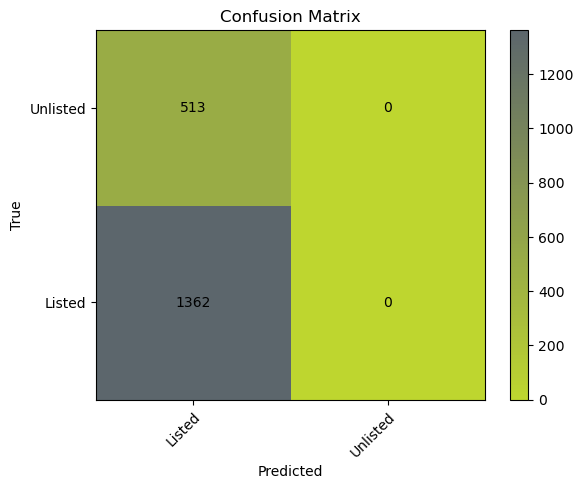

In [ ]:
plot_cm(confusion_matrix(y_val, knn_tfidf_y_val_pred), list(labels.keys()))

**2) With SMOTE**

In [ ]:
smote = SMOTE()
X_train_smote_tf, y_train_smote_tf = smote.fit_resample(X_train_tfidf, y_train.values)
print(X_train_smote_tf.shape, y_train_smote_tf.shape)

(6356, 13571) (6356,)


In [ ]:
knn_tfidf_s=KNeighborsClassifier()

knn_tfidf_s.fit(X_train_smote_tf, y_train_smote_tf)

knn_tfidf_s_y_val_pred = knn_tfidf_s.predict(X_val_tfidf)

print(classification_report(y_val, knn_tfidf_s_y_val_pred, target_names = labels.keys()))


              precision    recall  f1-score   support

      Listed       0.73      0.99      0.84      1362
    Unlisted       0.30      0.02      0.03       513

    accuracy                           0.72      1875
   macro avg       0.51      0.50      0.43      1875
weighted avg       0.61      0.72      0.62      1875



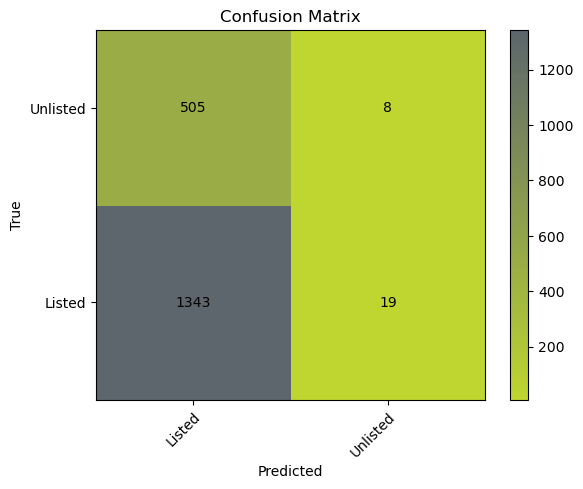

In [ ]:
plot_cm(confusion_matrix(y_val, knn_tfidf_s_y_val_pred), list(labels.keys()))

#### **5.1.2 Glove**

**1) Without SMOTE**

In [ ]:
knn_glove=KNeighborsClassifier(weights ='distance', n_jobs = -1)

knn_glove.fit(X_train_g, y_train)

knn_glove_y_val_pred = knn_glove.predict(X_val_g)

print(classification_report(y_val, knn_glove_y_val_pred, target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, knn_glove_y_val_pred), list(labels.keys()))

**2) With SMOTE**

In [ ]:
smote = SMOTE()
X_train_smote_g, y_train_smote_g = smote.fit_resample(X_train_g, y_train.values)
print(X_train_smote_g.shape, y_train_smote_g.shape)

In [ ]:
knn_glove_s=KNeighborsClassifier(weights ='distance', n_jobs = -1)

knn_glove_s.fit(X_train_smote_g, y_train_smote_g)

knn_glove_s_y_val_pred = knn_glove.predict(X_val_g)

print(classification_report(y_val, knn_glove_s_y_val_pred, target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, knn_glove_s_y_val_pred), list(labels.keys()))

#### **5.1.3 BERT**

**1) Without SMOTE**

**2) With SMOTE**

#### **5.1.4 SENTENCE TRANSFORMER**

**1) Without SMOTE**

In [ ]:
knn_st=KNeighborsClassifier(weights ='distance', n_jobs = -1)

knn_st.fit(X_train_str, y_train)

knn_st_y_val_pred = knn_st.predict(X_val_str)

print(classification_report(y_val, knn_st_y_val_pred, target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, knn_st_y_val_pred), list(labels.keys()))

**2) With SMOTE**

In [ ]:
smote = SMOTE()
X_train_smote_st, y_train_smote_st = smote.fit_resample(X_train_st, y_train.values)
print(X_train_smote_st.shape, y_train_smote_st.shape)

In [ ]:
knn_st_s=KNeighborsClassifier(weights ='distance', n_jobs = -1)

knn_st_s.fit(X_train_smote_st, y_train_smote_st)

knn_st_s_y_val_pred = knn_glove.predict(X_val_str)

print(classification_report(y_val, knn_st_s_y_val_pred, target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, knn_st_s_y_val_pred), list(labels.keys()))

### **5.2 Logistic Regression**: 

#### **5.2.1 TF-IDF**

In [52]:
lr_tfidf = LogisticRegression(class_weight='balanced', n_jobs = -1)

In [82]:
lr_tfidf.fit(X_train_tfidf, y_train)
print('model fit')

lr_tfidf_y_val_pred= lr_tfidf.predict(X_val_tfidf)
print(classification_report(y_val, lr_tfidf_y_val_pred, target_names=labels))

              precision    recall  f1-score   support

      Listed       0.95      0.82      0.88      1362
    Unlisted       0.65      0.88      0.75       513

    accuracy                           0.84      1875
   macro avg       0.80      0.85      0.82      1875
weighted avg       0.87      0.84      0.85      1875



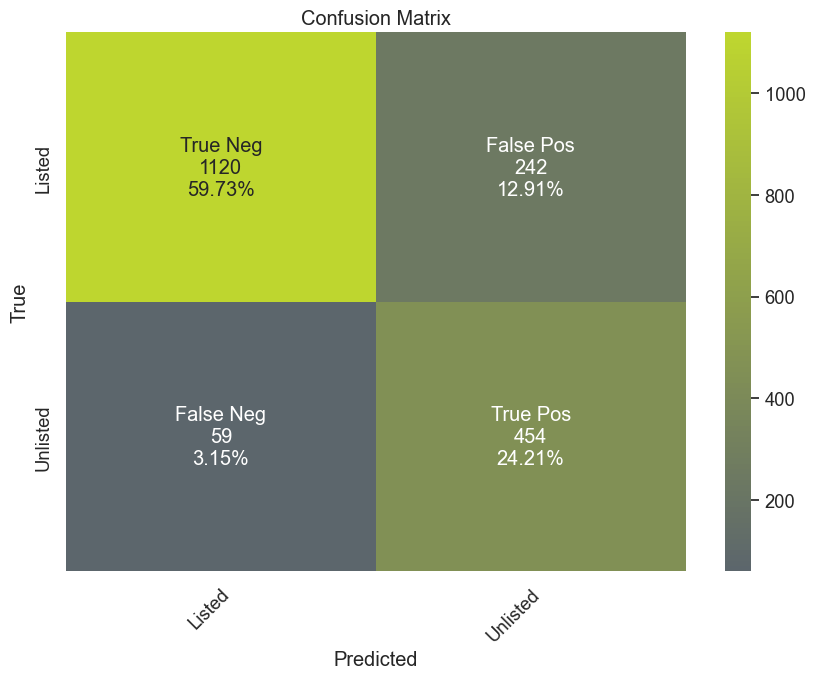

In [69]:
plot_cm(confusion_matrix(y_val, lr_tfidf_y_val_pred), labels)

#### **5.2.2 GloVE**

In [70]:
lr_glove = LogisticRegression(class_weight='balanced', n_jobs = -1)

In [92]:
print("X_train_g shape:", np.array(X_train_g).shape)
print("X_val_g shape:", np.array(X_val_g).shape)
print("X_train_g type:", type(X_train_g))
print("X_val_g type:", type(X_val_g))

X_train_g shape: (4373,)
X_val_g shape: (1875,)
X_train_g type: <class 'numpy.ndarray'>
X_val_g type: <class 'numpy.ndarray'>


In [107]:
lr_glove.fit(X_train_g.tolist(), y_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4373,) + inhomogeneous part.

In [ ]:
# Make predictions on the validation data
y_val_pred_lr_glove = logistic_classifier.predict(X_val_ge['comments_and_desc_glove_embeddings'].tolist())

# Calculate the classification report
print(classification_report(y_val_ge, y_val_pred_lr_glove))

# Calculate the confusion matrix
print(confusion_matrix(y_val_ge, y_val_pred_lr_glove))

In [91]:


lr_glove_y_val_pred= lr_glove.predict(X_val_g)

print(classification_report(y_val, lr_glove_y_val_pred))

ValueError: setting an array element with a sequence.

In [ ]:
plot_cm(confusion_matrix(y_val, lr_glove_y_val_pred), list(labels.keys()))

#### **5.2.3 BERT**

In [ ]:
lr_bert=LogisticRegression(class_weight='balanced', n_jobs = -1)

In [ ]:
lr_bert.fit(X_train_b, y_train)

lr_bert_y_val_pred= lr_bert.predict(X_val_b)

print(classification_report(y_val, lr_bert_y_val_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1362
           1       0.00      0.00      0.00       513

    accuracy                           0.73      1875
   macro avg       0.36      0.50      0.42      1875
weighted avg       0.53      0.73      0.61      1875



c:\Users\maria\Documents\ANACONDA\envs\environment_ML\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\Documents\ANACONDA\envs\environment_ML\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\Documents\ANACONDA\envs\environment_ML\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

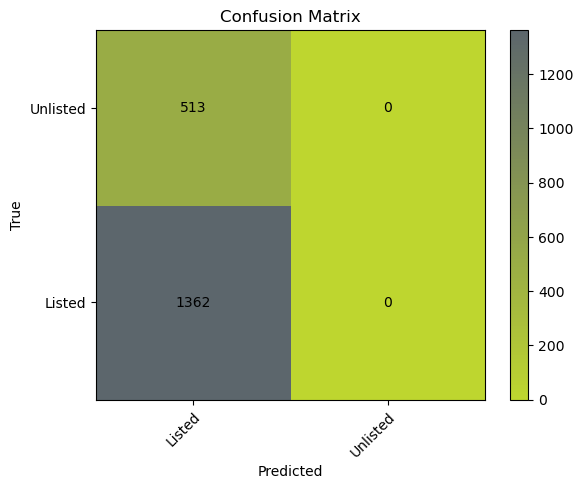

In [ ]:
plot_cm(confusion_matrix(y_val, lr_bert_y_val_pred), list(labels.keys()))

#### **5.2.4 Setence Transformer**

In [72]:
lr_st=LogisticRegression(class_weight='balanced', n_jobs = -1)

In [83]:
lr_st.fit(X_train_str, y_train)

lr_st_y_val_pred= lr_st.predict(X_val_str)

print(classification_report(y_val, lr_st_y_val_pred,target_names=labels))

              precision    recall  f1-score   support

      Listed       0.94      0.84      0.89      1362
    Unlisted       0.67      0.87      0.76       513

    accuracy                           0.85      1875
   macro avg       0.81      0.85      0.82      1875
weighted avg       0.87      0.85      0.85      1875



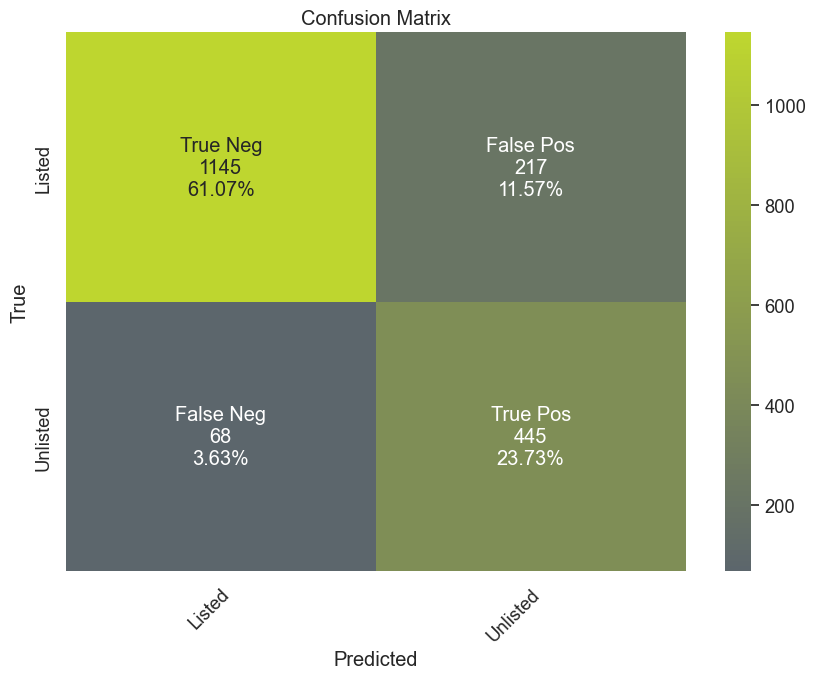

In [84]:
plot_cm(confusion_matrix(y_val, lr_st_y_val_pred), labels)

### **5.3 Naive Bayes**: 

#### **5.3.1 TF-IDF**

#### **5.3.2 GloVE**

#### **5.3.3 BERT**

#### **5.3.4 Setence Transformer**

### **5.4 Random Forest**: 

#### **5.4.1 TF-IDF**

#### **5.4.2 GloVE**

#### **5.4.3 BERT**

#### **5.4.4 Setence Transformer**

### **5.5  XGBOOST**:  I WOULD DO ONLY ONE OF THESE TO COMPARE PERFORMANCE - IF IT'S WORSE DON'T DO MORE

#### **5.5.1 TF-IDF**

#### **5.5.2 GloVE**

#### **5.5.3 BERT**

#### **5.5.4 Setence Transformer**

----

### Evaluation:
Evaluate with, at least, Recall, Precision, Accuracy and F1-Score.


In [76]:
#Faz sentido avaliar a f1 score allem da weighted??
#as outras métricas acho que mais vale a weighted avg

| Model | Word Embedding | Inbalance Treated | Recall | Precision | Accuracy | F1-Score| Weighted_F1 |
|-------|----------------|-------------------|--------|-----------|----------|---------|-------------|
|  KNN  |     TF-IDF     |       NONE        |        |           |          |         |             |
|  KNN  |     TF-IDF     |       SMOTE       |        |           |          |         |             |
|  KNN  |     Glove      |       NONE        |        |           |          |         |             |
|  KNN  |     Glove      |       SMOTE       |        |           |          |         |             |
|  KNN  |     Glove      |       NONE        |        |           |          |         |             |
|  KNN  |     MiniLM     |       NONE        |        |           |          |         |             |
|  KNN  |     MiniLM     |       SMOTE       |        |           |          |         |             |
|  KNN  |     BERT       |       NONE        |        |           |          |         |             |
|  KNN  |    BERT        |       SMOTE       |        |           |          |         |             |
|  Logistic Regression |     TF-IDF   |      class_weight "balanced"   |     0.84   |      0.87     |      0.84    |         |      0.85       |
|  Logistic Regression |     TF-IDF   |      SMOTE  |        |           |          |         |             |
|  Logistic Regression |     Glove    |      class_weight "balanced"   |        |           |          |         |             |
|  Logistic Regression |     MiniLM   |      class_weight "balanced"   |     0.85   |      0.87     |     0.85     |         |    0.85         |
|  Logistic Regression |     BERT     |      class_weight "balanced"   |        |           |          |         |             |
|  Naive Bayes |     TF-IDF      |      class_weight "balanced"        |        |           |          |         |             |
|  Naive Bayes |     Glove       |      class_weight "balanced"        |        |           |          |         |             |
|  Naive Bayes |     MiniLM      |      class_weight "balanced"        |        |           |          |         |             |
|  Naive Bayes |     BERT        |      class_weight "balanced"        |        |           |          |         |             |
|  Random Forest |     TF-IDF    |      class_weight "balanced"        |        |           |          |         |             |
|  Random Forest |     Glove     |      class_weight "balanced"        |        |           |          |         |             |
|  Random Forest |     MiniLM    |      class_weight "balanced"        |        |           |          |         |             |
|  Random Forest |     BERT      |      class_weight "balanced"        |        |           |          |         |             |
|  XGBoost       |     TF-IDF    |      class_weight "balanced"        |        |           |          |         |             |
|  XGBoost       |     Glove     |      class_weight "balanced"        |        |           |          |         |             |
|  XGboost       |     MiniLM    |      class_weight "balanced"        |        |           |          |         |             |
|  XGBoost       |     BERT      |      class_weight "balanced"        |        |           |          |         |             |



